## Dataset Column Descriptions

| **Column Name**        | **Description**                                                                |
|------------------------|--------------------------------------------------------------------------------|
| **flightdate**         | The date of the flight in YYYY-MM-DD format.                                   |
| **day_of_week**        | The day of the week the flight occurred (e.g., Monday, Tuesday).               |
| **airline**            | The airline operating the flight (e.g., Delta, United).                        |
| **tail_number**        | The unique identifier for the aircraft.                                        |
| **dep_airport**        | The IATA code of the departure airport.                                        |
| **dep_cityname**       | The name of the city where the departure airport is located.                   |
| **deptime_label**      | The time label of the flight's departure (e.g., morning, afternoon).           |
| **dep_delay**          | The delay time in minutes for the departure.                                   |
| **dep_delay_tag**      | Whether the flight was delayed or not.                                         |
| **dep_delay_type**     | The severity of the delay time (e.g., low, medium, high).                      |
| **arr_airport**        | The IATA code of the arrival airport.                                          |
| **arr_cityname**       | The name of the city where the arrival airport is located.                     |
| **arr_delay**          | The delay time in minutes for the arrival.                                     |
| **arr_delay_type**     | The severity of the delay time (e.g., low, medium, high).                      |
| **flight_duration**    | The total duration of the flight in minutes.                                   |
| **distance_type**      | A classification of the flight's distance (e.g., short-haul, long-haul).       |
| **delay_carrier**      | Delay time (in minutes) attributed to the carrier.                             |
| **delay_weather**      | Delay time (in minutes) caused by weather conditions.                          |
| **delay_nas**          | Delay time (in minutes) due to National Airspace System issues.                |
| **delay_security**     | Delay time (in minutes) due to security-related issues.                        |
| **delay_lastaircraft** | Delay time (in minutes) caused by the previous aircraft's issues.              |
| **manufacturer**       | The manufacturer of the aircraft (e.g., Boeing, Airbus).                       |
| **model**              | The specific model of the aircraft (e.g., 737-800, A320).                      |
| **aicraft_age**        | The age of the aircraft in years.                                              |
| **tavg**               | The average temperature (°C) on the flight date.                               |
| **tmin**               | The minimum temperature (°C) on the flight date.                               |
| **tmax**               | The maximum temperature (°C) on the flight date.                               |
| **prcp**               | The amount of precipitation (mm) on the flight date.                           |
| **snow**               | The amount of snowfall (mm) on the flight date.                                |
| **wdir**               | The wind direction (degrees) on the flight date.                       |
| **wspd**               | The wind speed (km/h) on the flight date.                              |
| **pres**               | The atmospheric pressure (hPa) on the flight date.                             |

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import boto3
from sklearn.preprocessing import StandardScaler, LabelEncoder
from io import BytesIO
from botocore.exceptions import NoCredentialsError, ClientError
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import datetime
from sklearn.feature_selection import mutual_info_classif

In [2]:
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

## Import Data from S3 Bucket

In [3]:
def read_csv_from_s3_as_df(bucket, key):
    try:
        # Create an S3 client
        s3 = boto3.client('s3')

        # Get the object from S3
        obj = s3.get_object(Bucket=bucket, Key=key)

        # Read the contents of the file into a pandas DataFrame
        df_pre_clean = pd.read_csv(BytesIO(obj['Body'].read()), header=0)

        return df_pre_clean
    except NoCredentialsError:
        print("Credentials not available")
    except ClientError as e:
        print(f"An error occurred: {e}")
    except Exception as e:
        print(f"An error occurred during DataFrame conversion: {e}")


bucket = 'baobucketaws'
key = 'asm3/raw/lax_merged.csv'
df = read_csv_from_s3_as_df(bucket, key)
if df is not None:
    print(df)
else:
    print("No data returned or error occurred")

        flightdate  day_of_week                 airline tail_number  \
0       2023-01-01            7  American Airlines Inc.      N101NN   
1       2023-01-02            1  American Airlines Inc.      N116AN   
2       2023-01-03            2  American Airlines Inc.      N107NN   
3       2023-01-04            3  American Airlines Inc.      N102NN   
4       2023-01-05            4  American Airlines Inc.      N110AN   
...            ...          ...                     ...         ...   
192255  2023-12-31            7         JetBlue Airways      N794JB   
192256  2023-12-31            7         JetBlue Airways      N991JT   
192257  2023-12-31            7         JetBlue Airways      N961JT   
192258  2023-12-31            7         JetBlue Airways      N979JT   
192259  2023-12-31            7         JetBlue Airways      N988JT   

       dep_airport     dep_cityname deptime_label  dep_delay  dep_delay_tag  \
0              LAX  Los Angeles, CA       Morning         -2        

## Data Exploration

In [4]:
df.dtypes

flightdate             object
day_of_week             int64
airline                object
tail_number            object
dep_airport            object
dep_cityname           object
deptime_label          object
dep_delay               int64
dep_delay_tag           int64
dep_delay_type         object
arr_airport            object
arr_cityname           object
arr_delay               int64
arr_delay_type         object
flight_duration         int64
distance_type          object
delay_carrier           int64
delay_weather           int64
delay_nas               int64
delay_security          int64
delay_lastaircraft      int64
manufacturer           object
model                  object
aicraft_age             int64
tavg                  float64
tmin                  float64
tmax                  float64
prcp                  float64
snow                  float64
wdir                  float64
wspd                  float64
pres                  float64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192260 entries, 0 to 192259
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   flightdate          192260 non-null  object 
 1   day_of_week         192260 non-null  int64  
 2   airline             192260 non-null  object 
 3   tail_number         192260 non-null  object 
 4   dep_airport         192260 non-null  object 
 5   dep_cityname        192260 non-null  object 
 6   deptime_label       192260 non-null  object 
 7   dep_delay           192260 non-null  int64  
 8   dep_delay_tag       192260 non-null  int64  
 9   dep_delay_type      192260 non-null  object 
 10  arr_airport         192260 non-null  object 
 11  arr_cityname        192260 non-null  object 
 12  arr_delay           192260 non-null  int64  
 13  arr_delay_type      192260 non-null  object 
 14  flight_duration     192260 non-null  int64  
 15  distance_type       192260 non-nul

In [6]:
df.head(5)

,flightdate,day_of_week,airline,tail_number,dep_airport,dep_cityname,deptime_label,dep_delay,dep_delay_tag,dep_delay_type,arr_airport,arr_cityname,arr_delay,arr_delay_type,flight_duration,distance_type,delay_carrier,delay_weather,delay_nas,delay_security,delay_lastaircraft,manufacturer,model,aicraft_age,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
0,2023-01-01,7,American Airlines Inc.,N101NN,LAX,"Los Angeles, CA",Morning,-2,0,Low <5min,JFK,"New York, NY",-52,Low <5min,280,Medium Haul <3000Mi,0,0,0,0,0,AIRBUS,A321,11,14.3,12.2,16.1,2.5,0.0,273.0,23.0,1007.9
1,2023-01-02,1,American Airlines Inc.,N116AN,LAX,"Los Angeles, CA",Morning,-6,0,Low <5min,JFK,"New York, NY",-27,Low <5min,309,Medium Haul <3000Mi,0,0,0,0,0,AIRBUS,A321,10,12.3,7.8,14.4,0.8,0.0,31.0,9.0,1015.0
2,2023-01-03,2,American Airlines Inc.,N107NN,LAX,"Los Angeles, CA",Morning,-2,0,Low <5min,JFK,"New York, NY",-23,Low <5min,309,Medium Haul <3000Mi,0,0,0,0,0,AIRBUS,A321,10,11.9,10.0,14.4,1.3,0.0,69.0,19.8,1017.1
3,2023-01-04,3,American Airlines Inc.,N102NN,LAX,"Los Angeles, CA",Morning,-3,0,Low <5min,JFK,"New York, NY",-3,Low <5min,330,Medium Haul <3000Mi,0,0,0,0,0,AIRBUS,A321,11,14.4,13.9,16.1,13.7,0.0,99.0,16.9,1018.2
4,2023-01-05,4,American Airlines Inc.,N110AN,LAX,"Los Angeles, CA",Morning,-3,0,Low <5min,JFK,"New York, NY",3,Low <5min,336,Medium Haul <3000Mi,0,0,0,0,0,AIRBUS,A321,10,14.6,12.8,16.7,27.2,0.0,224.0,20.9,1018.4


In [7]:
df.describe()

,day_of_week,dep_delay,dep_delay_tag,arr_delay,flight_duration,delay_carrier,delay_weather,delay_nas,delay_security,delay_lastaircraft,aicraft_age,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
count,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.000000,192260.0,192260.000000,192260.000000,192260.000000
mean,3.969817,11.172579,0.369021,4.131785,188.740378,5.119396,0.283736,2.163497,0.022922,4.882092,11.295917,16.715671,13.382647,20.826685,1.685186,0.0,228.210410,12.123309,1015.157275
std,1.998595,52.132922,0.482541,53.791326,94.655065,34.769585,9.079882,12.397414,1.267490,30.628995,8.372939,3.180804,3.697169,3.836943,6.892591,0.0,87.307989,3.750177,3.563641
min,1.000000,-30.000000,0.000000,-74.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.800000,5.000000,11.700000,0.000000,0.0,0.000000,5.000000,1002.900000
25%,2.000000,-5.000000,0.000000,-16.000000,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,14.100000,10.600000,17.800000,0.000000,0.0,216.000000,9.700000,1012.800000
50%,4.000000,-2.000000,0.000000,-7.000000,178.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,16.700000,13.900000,20.600000,0.000000,0.0,253.000000,11.500000,1014.800000
75%,6.000000,8.000000,1.000000,7.000000,275.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,19.300000,16.100000,23.900000,0.000000,0.0,274.000000,13.300000,1017.300000
max,7.000000,2386.000000,1.000000,2426.000000,507.000000,2386.000000,1103.000000,774.000000,281.000000,2098.000000,48.000000,24.400000,20.600000,32.800000,51.800000,0.0,359.000000,42.100000,1026.200000


+ Negative values in the `dep_delay` column means that the flight departed earlier than the scheduled time.
+ Negative values in the `arr_delay` column means that the flight arrived earlier than the scheduled time.

## Data Cleaning

In [8]:
df["flightdate"] = pd.to_datetime(df["flightdate"])

In [9]:
df["flightdate"].head()

0   2023-01-01
1   2023-01-02
2   2023-01-03
3   2023-01-04
4   2023-01-05
Name: flightdate, dtype: datetime64[ns]

In [10]:
# Extract Month, Day, and Quarter

df['month'] = df['flightdate'].dt.month

df['day'] = df['flightdate'].dt.day

df['quarter'] = df['flightdate'].dt.quarter

In [11]:
missing = pd.DataFrame(df.isna().sum(), columns=["Null Values"])

missing

,Null Values
flightdate,0
day_of_week,0
airline,0
tail_number,0
dep_airport,0
dep_cityname,0
deptime_label,0
dep_delay,0
dep_delay_tag,0
dep_delay_type,0


In [12]:
# Drop duplicated rows, keep the first occurrence of each unique row
df = df.drop_duplicates()

In [13]:
df.shape

(192259, 35)

In [14]:
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    print(f'Duplicate rows found:\n{duplicate_rows}')
else:
    print('No duplicate rows found.')

No duplicate rows found.


In [15]:
num_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"]]

cat_cols = [col for col in df.columns if df[col].dtype == "object"]

In [16]:
print(f"Numerical Columns: {num_cols} with count of {len(num_cols)}","\n")

print(f"Categorical Columns: {cat_cols} with count of {len(cat_cols)}")

Numerical Columns: ['day_of_week', 'dep_delay', 'dep_delay_tag', 'arr_delay', 'flight_duration', 'delay_carrier', 'delay_weather', 'delay_nas', 'delay_security', 'delay_lastaircraft', 'aicraft_age', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'month', 'day', 'quarter'] with count of 22 

Categorical Columns: ['airline', 'tail_number', 'dep_airport', 'dep_cityname', 'deptime_label', 'dep_delay_type', 'arr_airport', 'arr_cityname', 'arr_delay_type', 'distance_type', 'manufacturer', 'model'] with count of 12


In [17]:
df_cleaned = df.copy()

In [18]:
pd.DataFrame(df["day_of_week"].value_counts())

,day_of_week
5,28686
4,28654
1,28537
7,27730
3,27190
2,26951
6,24511


In [19]:
# 1 for Monday and 7 for Sunday

# added 1 to x as it supposed to be from 0 (Monday) to 6 (Sunday)

df_cleaned["day_of_week"] = df_cleaned["day_of_week"].apply(lambda x: datetime.date(2023, 1, x+1).strftime('%A'))

In [20]:
pd.DataFrame(df_cleaned["day_of_week"].value_counts())

,day_of_week
Friday,28686
Thursday,28654
Monday,28537
Sunday,27730
Wednesday,27190
Tuesday,26951
Saturday,24511


In [21]:
pd.DataFrame(df_cleaned["month"].value_counts())

,month
8,17458
7,17253
10,16763
5,16616
6,16498
9,16008
12,15885
11,15707
3,15703
4,15428


In [22]:
# Extract Month names directly

df_cleaned["month"] = df_cleaned['flightdate'].dt.strftime('%B')

In [23]:
pd.DataFrame(df_cleaned["month"].value_counts())

,month
August,17458
July,17253
October,16763
May,16616
June,16498
September,16008
December,15885
November,15707
March,15703
April,15428


In [24]:
for col in df_cleaned.columns:

    print(f"{col} : {df_cleaned[col].nunique()}")

    if df_cleaned[col].nunique() < 40:

        print(f"{col} : {df_cleaned[col].unique()}")

        print("-" * 80)

flightdate : 365
day_of_week : 7
day_of_week : ['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']
--------------------------------------------------------------------------------
airline : 10
airline : ['American Airlines Inc.' 'Alaska Airlines Inc.' 'JetBlue Airways'
 'Delta Air Lines Inc' 'Allegiant Air' 'Hawaiian Airlines Inc.'
 'Spirit Air Lines' 'Southwest Airlines Co.' 'Skywest Airlines Inc.'
 'United Air Lines Inc.']
--------------------------------------------------------------------------------
tail_number : 4571
dep_airport : 1
dep_airport : ['LAX']
--------------------------------------------------------------------------------
dep_cityname : 1
dep_cityname : ['Los Angeles, CA']
--------------------------------------------------------------------------------
deptime_label : 4
deptime_label : ['Morning' 'Evening' 'Afternoon' 'Night']
--------------------------------------------------------------------------------
dep_delay : 787
dep_delay_tag : 2
dep_del

In [25]:
for col in df_cleaned.columns:

    if df_cleaned[col].nunique() < 40:

        print(pd.DataFrame(df_cleaned[col].value_counts()))

        print("-" * 80)

           day_of_week
Friday           28686
Thursday         28654
Monday           28537
Sunday           27730
Wednesday        27190
Tuesday          26951
Saturday         24511
--------------------------------------------------------------------------------
                        airline
Delta Air Lines Inc       36556
Skywest Airlines Inc.     35191
American Airlines Inc.    29028
Southwest Airlines Co.    28967
United Air Lines Inc.     25269
Spirit Air Lines          12524
JetBlue Airways           11943
Alaska Airlines Inc.       9299
Hawaiian Airlines Inc.     2169
Allegiant Air              1313
--------------------------------------------------------------------------------
     dep_airport
LAX       192259
--------------------------------------------------------------------------------
                 dep_cityname
Los Angeles, CA        192259
--------------------------------------------------------------------------------
           deptime_label
Morning            78

## Check Correlation

In [26]:
def HeatMap(dataframe, title="Correlation Plot", figsize=(12, 10), vmin=-1, vmax=1):
    corr = dataframe.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=figsize)

    colormap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.heatmap(
        corr,
        mask=mask,
        cmap=colormap,
        vmin=vmin, vmax=vmax,
        square=True,
        cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
        annot=True,
        annot_kws={'fontsize': 10},
        linewidths=0.5,
        fmt=".2f"
    )

    # Set axis labels and title
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=16, weight='bold')
    plt.show()

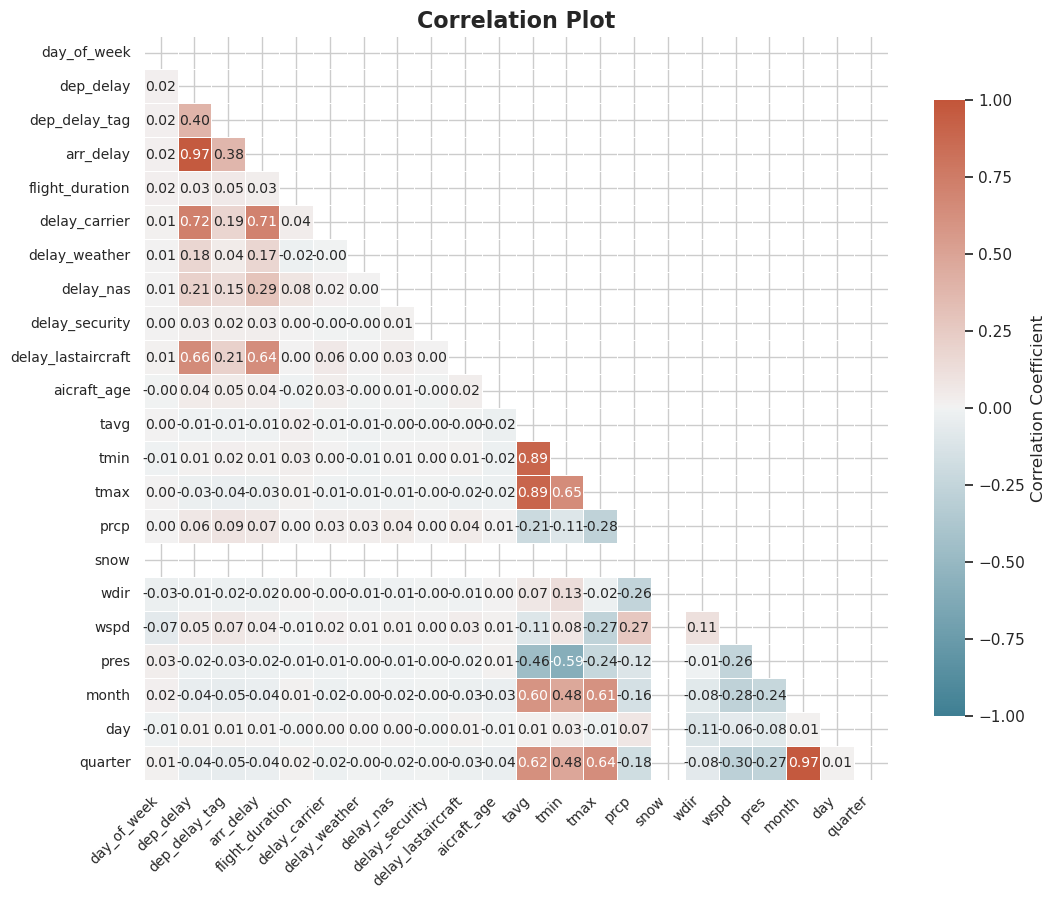

In [27]:
HeatMap(df, "Correlation Plot")

+ There is a high correlation between Month and Quarter columns
+ There is a high correlation between tmin, tmax and tavg columns
+ There is a high correlation between Arr_Delay and Dep_Delay columns

In [28]:
cat_corr = pd.DataFrame(columns=["feature", "cramer's v", "chi-square", "p-value"])

# Create a contingency table for a categorical feature and the target column
for col in cat_cols:
    contingency_table = pd.crosstab(df[col], df['dep_delay_tag'])
    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate Cramér’s V
    n = contingency_table.sum().sum()

    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))
    # Create a temporary DataFrame for the current feature
    temp_df = pd.DataFrame({
        "feature": [col],
        "chi-square": [chi2],
        "p-value": [round(p, 6)],
        "cramer's v": [cramers_v]
    })
    # Use pd.concat() to append the temp_df to cat_corr
    cat_corr = pd.concat([cat_corr, temp_df], ignore_index=True)

In [29]:
cat_corr

,feature,cramer's v,chi-square,p-value
0,airline,0.223225,9580.131991,0.0
1,tail_number,0.306901,18108.495851,0.0
2,dep_airport,NaN,0.000000,1.0
3,dep_cityname,NaN,0.000000,1.0
4,deptime_label,0.126965,3099.218565,0.0
5,dep_delay_type,0.623118,74649.495850,0.0
6,arr_airport,0.178390,6118.271558,0.0
7,arr_cityname,0.162354,5067.696607,0.0
8,arr_delay_type,0.509427,49894.270244,0.0
9,distance_type,0.069548,929.949279,0.0


## Mutual Information

In [30]:
df_cpy = df.copy()

In [31]:
for col in cat_cols:

    cat_enc = LabelEncoder()

    df_cpy[col] = cat_enc.fit_transform(df_cpy[col])

In [32]:
mi_data = pd.DataFrame()

mi_data['feature'] = df_cpy.columns

# Calculate mutual information for each categorical feature with the target
mi_data['mutual information'] = [mutual_info_classif(df_cpy[[col]], df_cpy['dep_delay_tag'], random_state= 42) for col in df_cpy.columns]

In [33]:
mi_data = mi_data.sort_values(by="mutual information", ascending=False)

mi_data

,feature,mutual information
8,dep_delay_tag,[0.6756092918339363]
7,dep_delay,[0.6585767125181872]
9,dep_delay_type,[0.24756728122978577]
12,arr_delay,[0.2075897971132632]
13,arr_delay_type,[0.15937097056910932]
16,delay_carrier,[0.10868950581262582]
20,delay_lastaircraft,[0.09675297839960573]
18,delay_nas,[0.04994395842914878]
3,tail_number,[0.037043536421313084]
2,airline,[0.028689532685055807]


In [34]:
cat_corr["mutual information"] = [mutual_info_classif(df_cpy[[col]], df_cpy['dep_delay_tag'], random_state=42) for col in cat_cols]

In [35]:
cat_corr = cat_corr.sort_values(by="mutual information", ascending=False)

cat_corr

,feature,cramer's v,chi-square,p-value,mutual information
5,dep_delay_type,0.623118,74649.495850,0.0,[0.24756728122978577]
8,arr_delay_type,0.509427,49894.270244,0.0,[0.15937097056910932]
1,tail_number,0.306901,18108.495851,0.0,[0.037043536421313084]
0,airline,0.223225,9580.131991,0.0,[0.028689532685055807]
9,distance_type,0.069548,929.949279,0.0,[0.021826484646510824]
11,model,0.173074,5759.069127,0.0,[0.02065709426231499]
10,manufacturer,0.161817,5034.238700,0.0,[0.01990560965527899]
4,deptime_label,0.126965,3099.218565,0.0,[0.018525765093104773]
6,arr_airport,0.178390,6118.271558,0.0,[0.018133694183940285]
7,arr_cityname,0.162354,5067.696607,0.0,[0.01555755761681854]


In [36]:
cat_corr[cat_corr["mutual information"] > 0.1]

,feature,cramer's v,chi-square,p-value,mutual information
5,dep_delay_type,0.623118,74649.495850,0.0,[0.24756728122978577]
8,arr_delay_type,0.509427,49894.270244,0.0,[0.15937097056910932]


These are the features with mutual information of larger than 10% with target column `dep_delay_tag`

## Check Multicollinearity

In [37]:
# Drop target and datetime columns

multico_data = df.drop(["flightdate", "dep_delay_tag"], axis=1)

In [38]:
# Encoding Categorical features
for col in cat_cols:
    label = LabelEncoder()
    multico_data[col] = label.fit_transform(multico_data[col])

# Standardizing the features
multico_data_scaled = StandardScaler().fit_transform(multico_data)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = multico_data.columns
vif_data['vif'] = [variance_inflation_factor(multico_data_scaled, i) for i in range(multico_data_scaled.shape[1])]

In [39]:
vif_data = vif_data.sort_values(by="vif", ascending=False)

vif_data

,feature,vif
22,tavg,33.693237
6,dep_delay,32.276122
10,arr_delay,26.941593
14,delay_carrier,20.101335
32,quarter,19.873529
30,month,18.351400
18,delay_lastaircraft,16.179118
24,tmax,12.458663
23,tmin,12.182783
12,flight_duration,5.564657


In [40]:
high_colinearity = vif_data[vif_data["vif"] > 4.5]

high_colinearity

,feature,vif
22,tavg,33.693237
6,dep_delay,32.276122
10,arr_delay,26.941593
14,delay_carrier,20.101335
32,quarter,19.873529
30,month,18.351400
18,delay_lastaircraft,16.179118
24,tmax,12.458663
23,tmin,12.182783
12,flight_duration,5.564657


In [41]:
moderate_colinearity = vif_data[(vif_data["vif"] < 4.5) & (vif_data["vif"] > 1.41)]

moderate_colinearity

,feature,vif
8,arr_airport,3.147806
16,delay_nas,2.996416
9,arr_cityname,2.736102
19,manufacturer,2.730256
20,model,2.388307
15,delay_weather,2.281376
29,pres,1.865999
7,dep_delay_type,1.814589
11,arr_delay_type,1.719643
28,wspd,1.434274


In [42]:
no_colinearity = vif_data[vif_data["vif"] < 1.41]

no_colinearity

,feature,vif
25,prcp,1.299823
27,wdir,1.202262
1,airline,1.195304
2,tail_number,1.152287
21,aicraft_age,1.138384
31,day,1.035576
17,delay_security,1.030772
5,deptime_label,1.025277
0,day_of_week,1.008764


In [43]:
print("Features with HIGH collinearity:", high_colinearity["feature"].to_list())

Features with HIGH collinearity: ['tavg', 'dep_delay', 'arr_delay', 'delay_carrier', 'quarter', 'month', 'delay_lastaircraft', 'tmax', 'tmin', 'flight_duration', 'distance_type']


In [44]:
print("Features with MODERATE collinearity:", moderate_colinearity["feature"].to_list())

Features with MODERATE collinearity: ['arr_airport', 'delay_nas', 'arr_cityname', 'manufacturer', 'model', 'delay_weather', 'pres', 'dep_delay_type', 'arr_delay_type', 'wspd']


In [45]:
print("Features with NO collinearity:", no_colinearity["feature"].to_list())

Features with NO collinearity: ['prcp', 'wdir', 'airline', 'tail_number', 'aicraft_age', 'day', 'delay_security', 'deptime_label', 'day_of_week']


## Check Skewness

In [46]:
skew_data = df.drop("flightdate", axis = 1)

In [47]:
skewness = pd.DataFrame()

skewness["features"] = df[num_cols].columns
skewness["skewness"] = [skew_data[col].skew() for col in num_cols]
skewness = skewness.sort_values(by="skewness", ascending=False)

skewness

,features,skewness
8,delay_security,103.273593
6,delay_weather,66.267072
9,delay_lastaircraft,19.982473
5,delay_carrier,18.922071
7,delay_nas,15.740869
1,dep_delay,11.556640
3,arr_delay,10.592609
14,prcp,5.136495
17,wspd,2.476822
10,aicraft_age,0.781653


In [48]:
# positive skewness (right-skewed)
pos_skew = skewness[skewness["skewness"] > 0.3]

pos_skew

,features,skewness
8,delay_security,103.273593
6,delay_weather,66.267072
9,delay_lastaircraft,19.982473
5,delay_carrier,18.922071
7,delay_nas,15.740869
1,dep_delay,11.556640
3,arr_delay,10.592609
14,prcp,5.136495
17,wspd,2.476822
10,aicraft_age,0.781653


In [49]:
# negative skewness (left-skewed)
neg_skew = skewness[skewness["skewness"] < -0.1]

neg_skew

,features,skewness
12,tmin,-0.201541
16,wdir,-1.189799


In [50]:
# no skewness with symmetrical distribution
no_skew = skewness[(skewness["skewness"] > -0.1) & (skewness["skewness"] < 0.3)]

no_skew

,features,skewness
4,flight_duration,0.240559
13,tmax,0.142380
0,day_of_week,0.019386
20,day,0.005088
15,snow,0.000000
11,tavg,-0.033673
19,month,-0.042732
21,quarter,-0.044577


In [51]:
print("Features with Right Skewness:", pos_skew["features"].to_list())

Features with Right Skewness: ['delay_security', 'delay_weather', 'delay_lastaircraft', 'delay_carrier', 'delay_nas', 'dep_delay', 'arr_delay', 'prcp', 'wspd', 'aicraft_age', 'dep_delay_tag', 'pres']


In [52]:
print("Features with Left Skewness:", neg_skew["features"].to_list())

Features with Left Skewness: ['tmin', 'wdir']


In [53]:
print("Features with Symmetrical Distribution:", no_skew["features"].to_list())

Features with Symmetrical Distribution: ['flight_duration', 'tmax', 'day_of_week', 'day', 'snow', 'tavg', 'month', 'quarter']


## Check Outliers

In [54]:
# Function used to detect Outliers , their counts and percentages

def iqr_outliers(data, num_columns):
    outlier_data = {}

    for col in num_columns:
        data_column = data[col]
        Q1 = data_column.quantile(0.25)
        Q3 = data_column.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data_column[(data_column < lower_bound) | (data_column > upper_bound)]
        outlier_counts = len(outliers)
        outlier_percentages = (outlier_counts / len(data_column)) * 100

        outlier_data[col] = {
            'count': outlier_counts,
            'percentage': outlier_percentages,
            'outliers': outliers.tolist()
        }
        if outlier_counts > 0:
            print(f"No. of IQR outliers in '{col}': {outlier_counts}")
            print(f"Percentage of outliers in '{col}': {outlier_percentages:.2f}%")
            print("-" * 80)

    return outlier_data

In [55]:
outliers = iqr_outliers(df, num_cols)

No. of IQR outliers in 'dep_delay': 24644
Percentage of outliers in 'dep_delay': 12.82%
--------------------------------------------------------------------------------
No. of IQR outliers in 'arr_delay': 16706
Percentage of outliers in 'arr_delay': 8.69%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_carrier': 21573
Percentage of outliers in 'delay_carrier': 11.22%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_weather': 646
Percentage of outliers in 'delay_weather': 0.34%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_nas': 16756
Percentage of outliers in 'delay_nas': 8.72%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_security': 137
Percentage of outliers in 'delay_security': 0.07%
-------------------------------------------------

## Handle Skewness and Outliers

In [56]:
df_skew = df.copy()

In [57]:
df_skew = df_skew.drop(["flightdate", "arr_delay", "dep_delay"], axis=1)

In [58]:
numerical_cols = [col for col in df_skew.columns if df_skew[col].dtype != "object"]

categorical_cols = [col for col in df_skew.columns if df_skew[col].dtype == "object"]

In [59]:
def get_best_threshold(z):
    for i in np.arange(3,5,0.2):
        data = df_skew.copy()
        data = data[(z < i).all(axis=1)]
        loss = (df.shape[0] - data.shape[0]) / df_skew.shape[0]*100
        print(f'Loss: {loss:.2}% when threshold is {i}')

In [60]:
from scipy.stats import zscore, skew, boxcox

z = np.abs(zscore(df[numerical_cols]))

get_best_threshold(z)

Loss: 1e+02% when threshold is 3.0
Loss: 1e+02% when threshold is 3.2
Loss: 1e+02% when threshold is 3.4000000000000004
Loss: 1e+02% when threshold is 3.6000000000000005
Loss: 1e+02% when threshold is 3.8000000000000007
Loss: 1e+02% when threshold is 4.000000000000001
Loss: 1e+02% when threshold is 4.200000000000001
Loss: 1e+02% when threshold is 4.400000000000001
Loss: 1e+02% when threshold is 4.600000000000001
Loss: 1e+02% when threshold is 4.800000000000002


In [61]:
# Function to plot the distribution and calculate skewness
def plot_skewness(df, column):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_skew[column], kde=True, palette='coolwarm')
    plt.title(f'Distribution of {column} (Skewness: {skew(df_skew[column])})')

    plt.subplot(1, 2, 2)
    sns.boxplot(df_skew[column], palette='coolwarm')
    plt.title(f'Boxplot of {column}')

    plt.tight_layout()

    plt.show()

In [62]:
# Initial skewness check
skewness_before = df_skew[numerical_cols].apply(skew)

print("Skewness before transformation:\n", skewness_before)

Skewness before transformation:
 day_of_week             0.019386
dep_delay_tag           0.542864
flight_duration         0.240557
delay_carrier          18.921924
delay_weather          66.266555
delay_nas              15.740746
delay_security        103.272787
delay_lastaircraft     19.982317
aicraft_age             0.781646
tavg                   -0.033672
tmin                   -0.201540
tmax                    0.142379
prcp                    5.136455
snow                         NaN
wdir                   -1.189790
wspd                    2.476803
pres                    0.320437
month                  -0.042732
day                     0.005088
quarter                -0.044577
dtype: float64



Processing column: dep_delay_tag


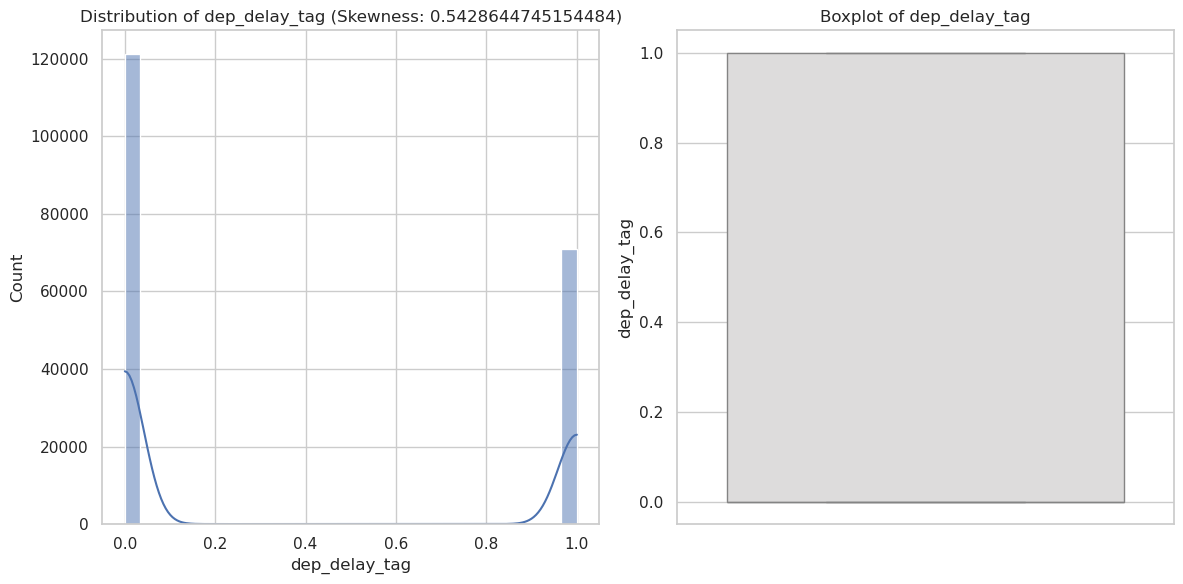

Square Root transformation skewness: 0.5428644745154484
Best transformation for dep_delay_tag: None


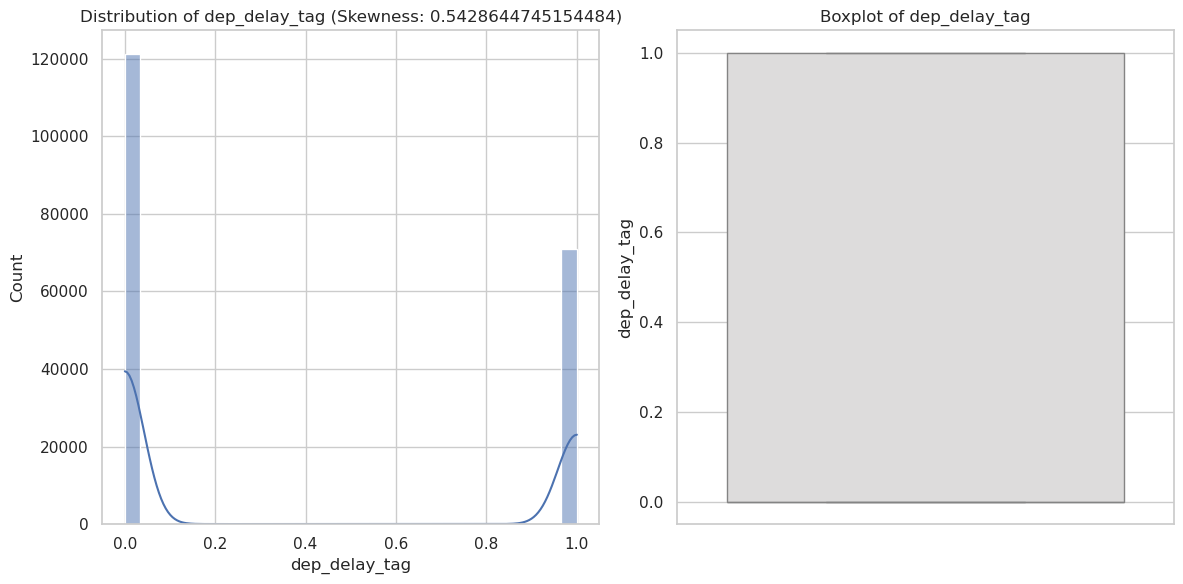


Processing column: delay_carrier


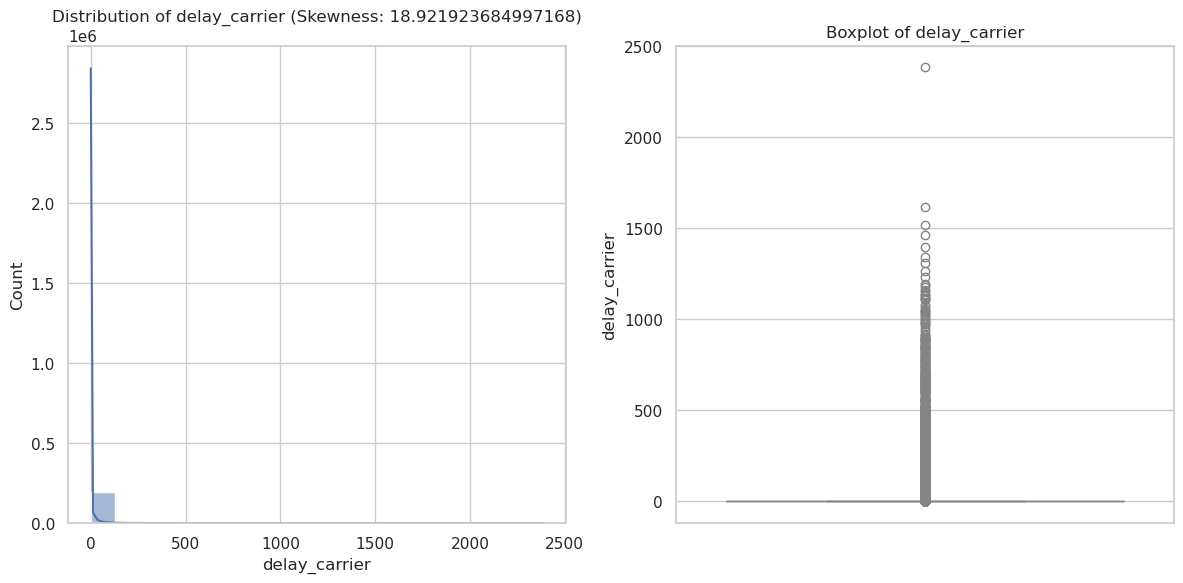

Square Root transformation skewness: 5.545713035746726
Best transformation for delay_carrier: Square Root


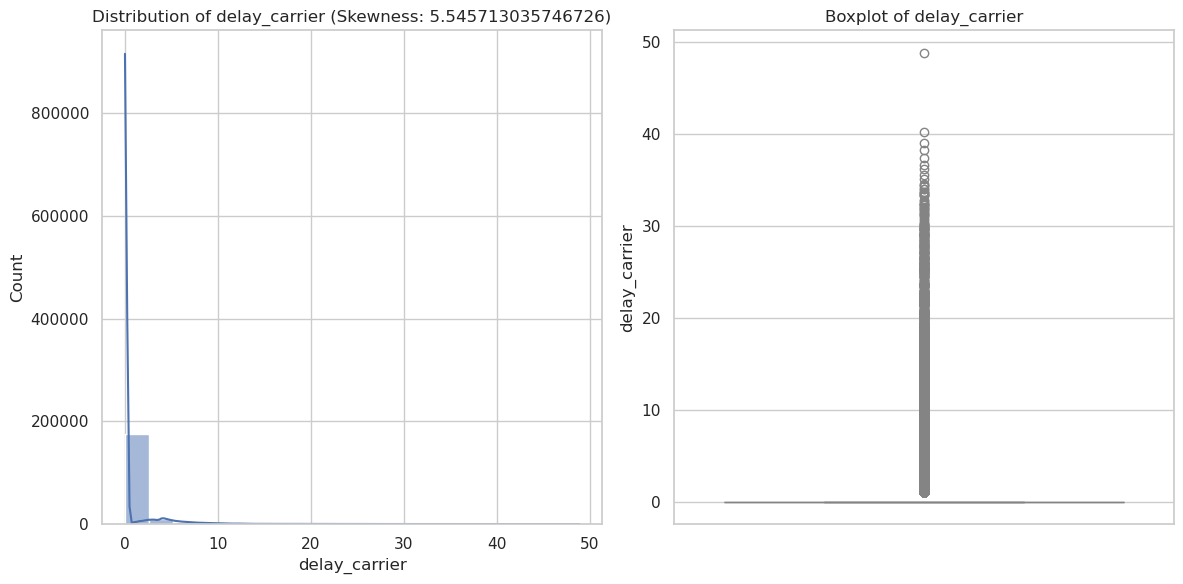


Processing column: delay_weather


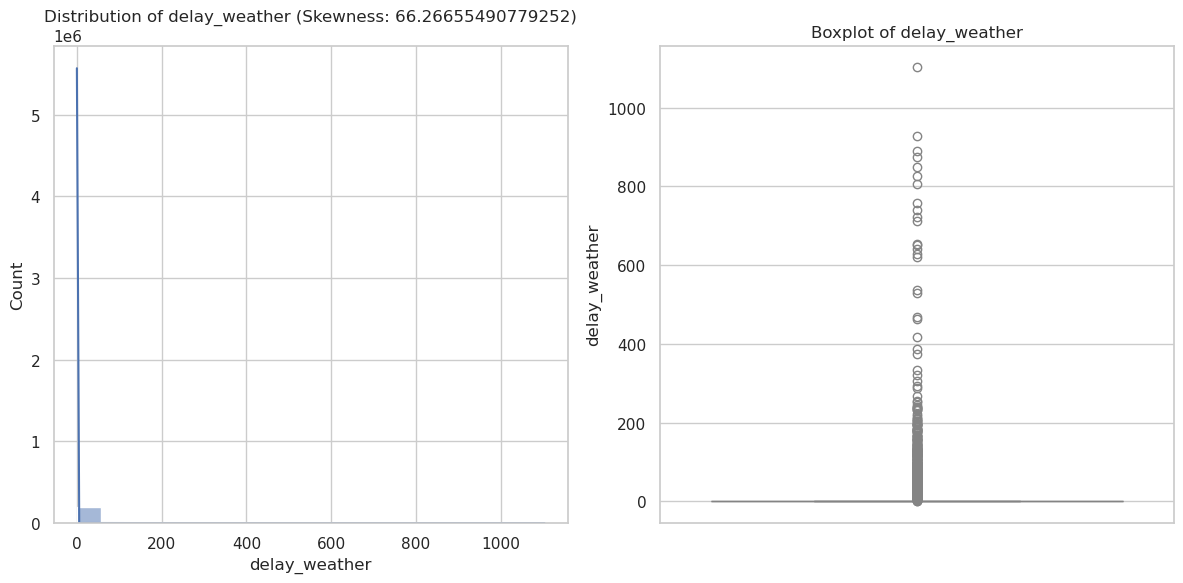

Square Root transformation skewness: 27.899701012738824
Best transformation for delay_weather: Square Root


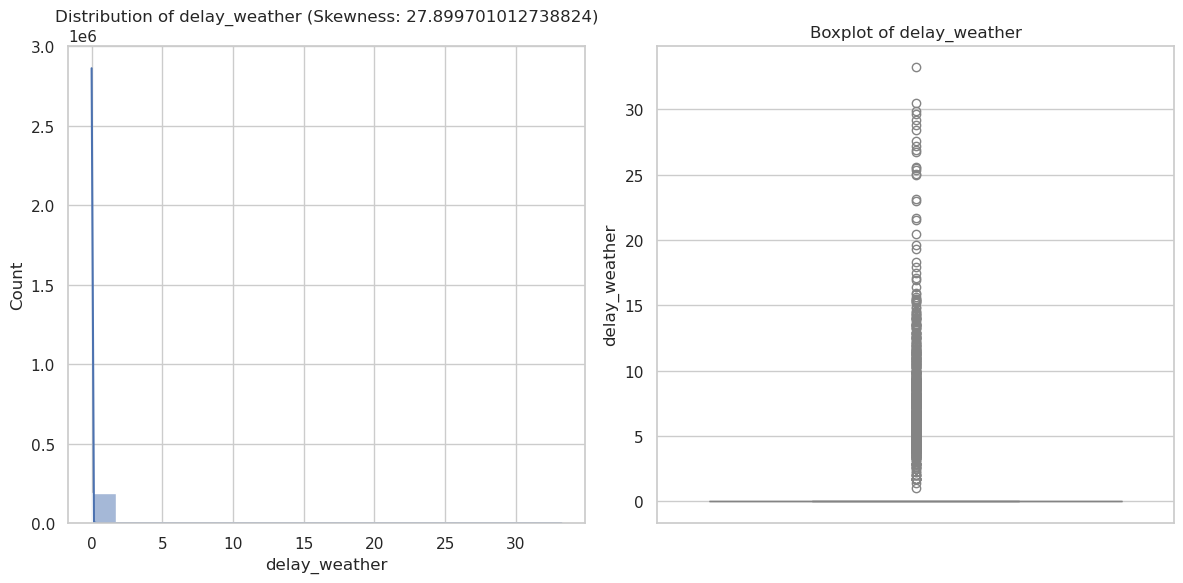


Processing column: delay_nas


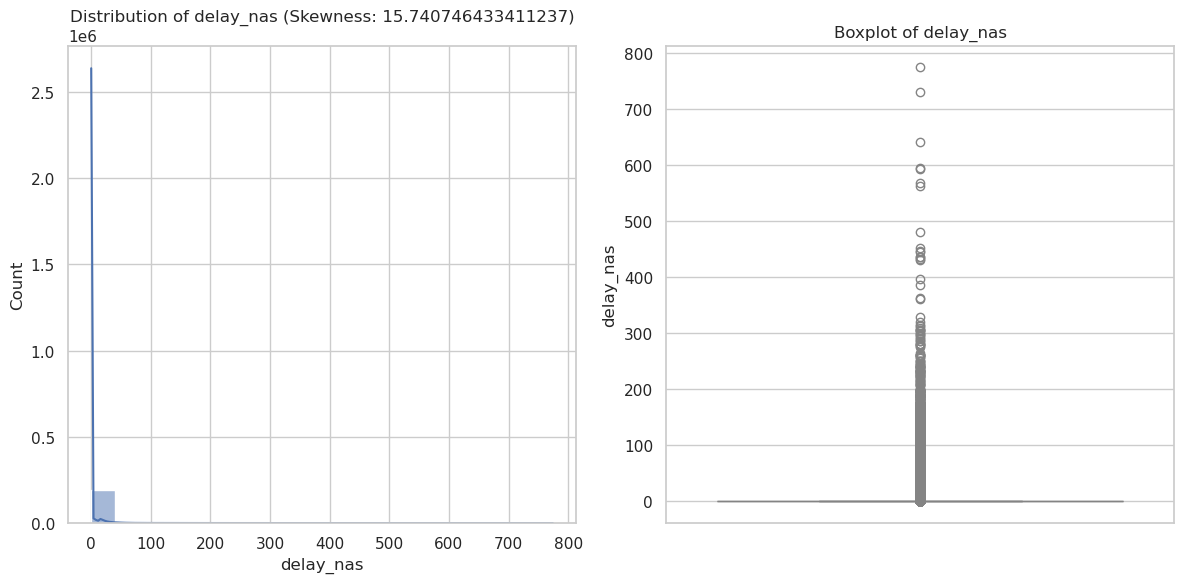

Square Root transformation skewness: 4.821742150035298
Best transformation for delay_nas: Square Root


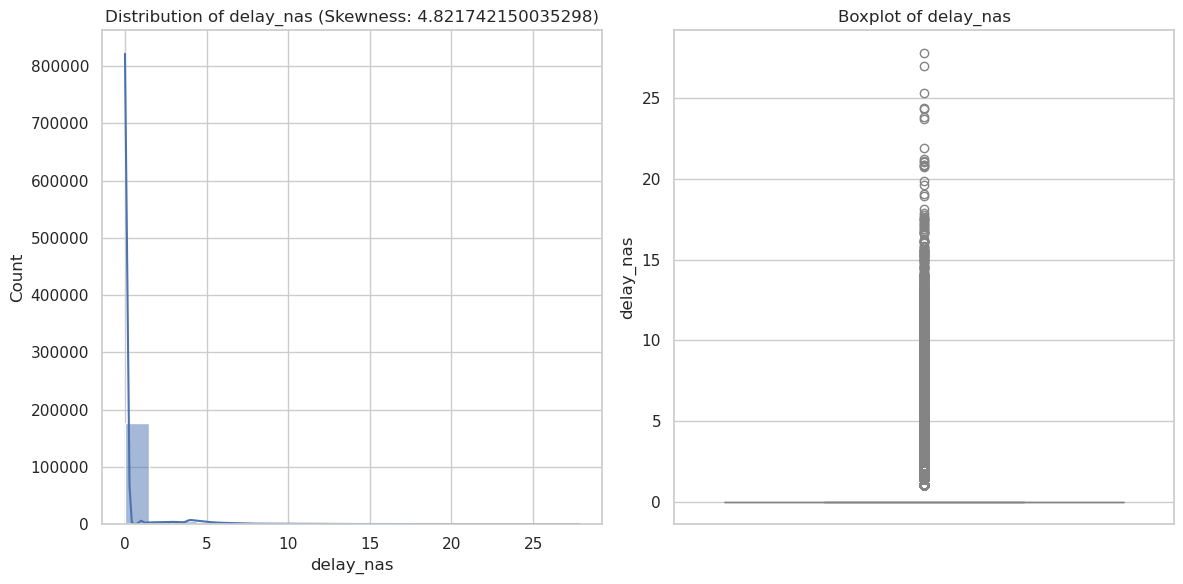


Processing column: delay_security


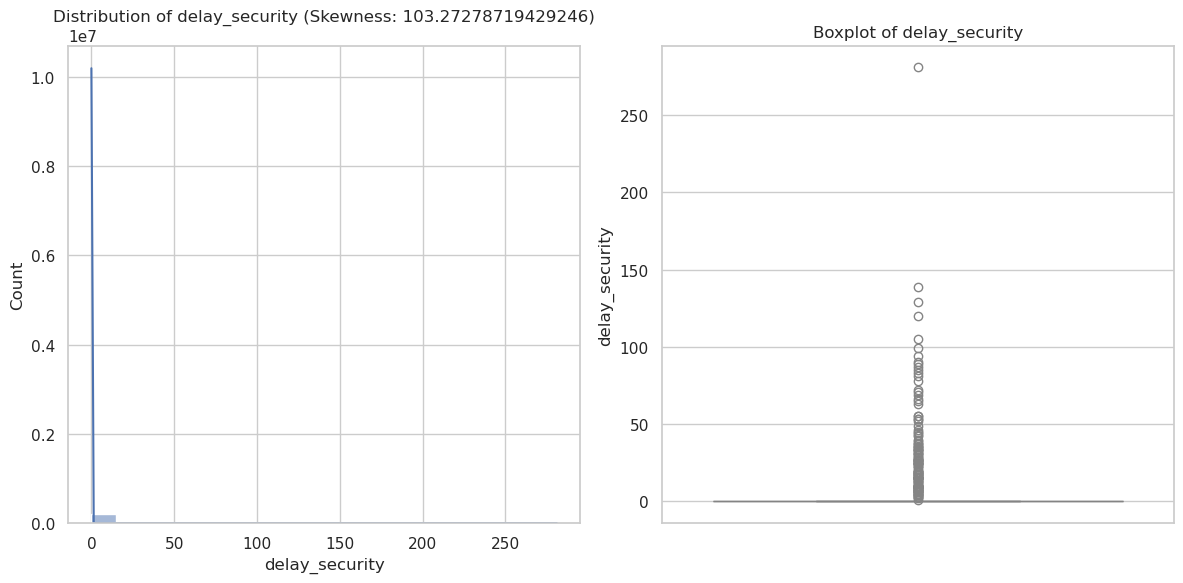

Square Root transformation skewness: 50.571999140568266
Best transformation for delay_security: Square Root


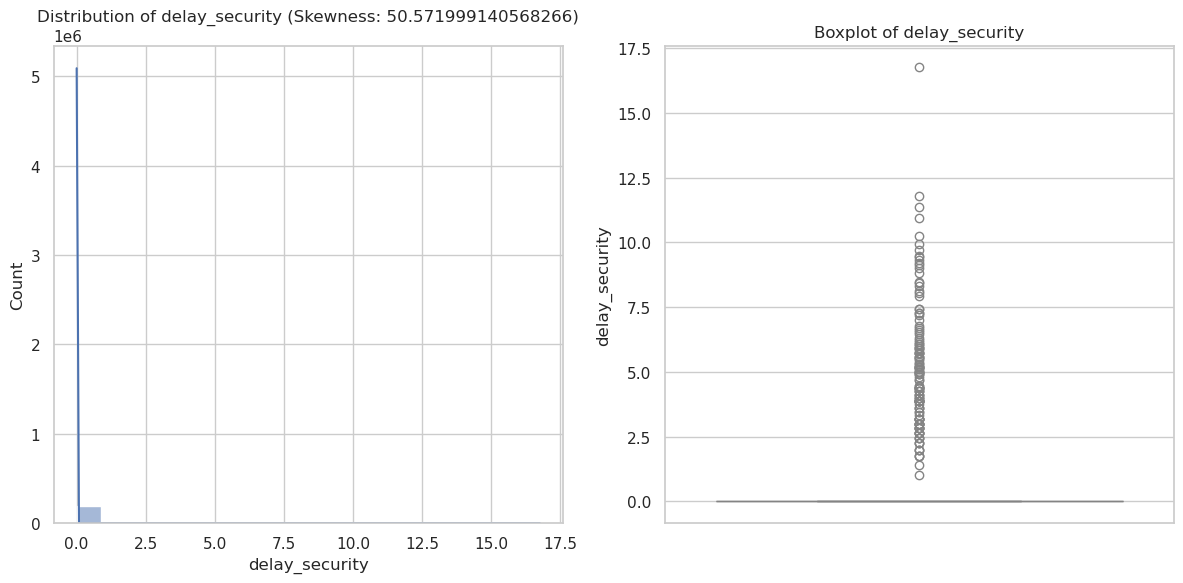


Processing column: delay_lastaircraft


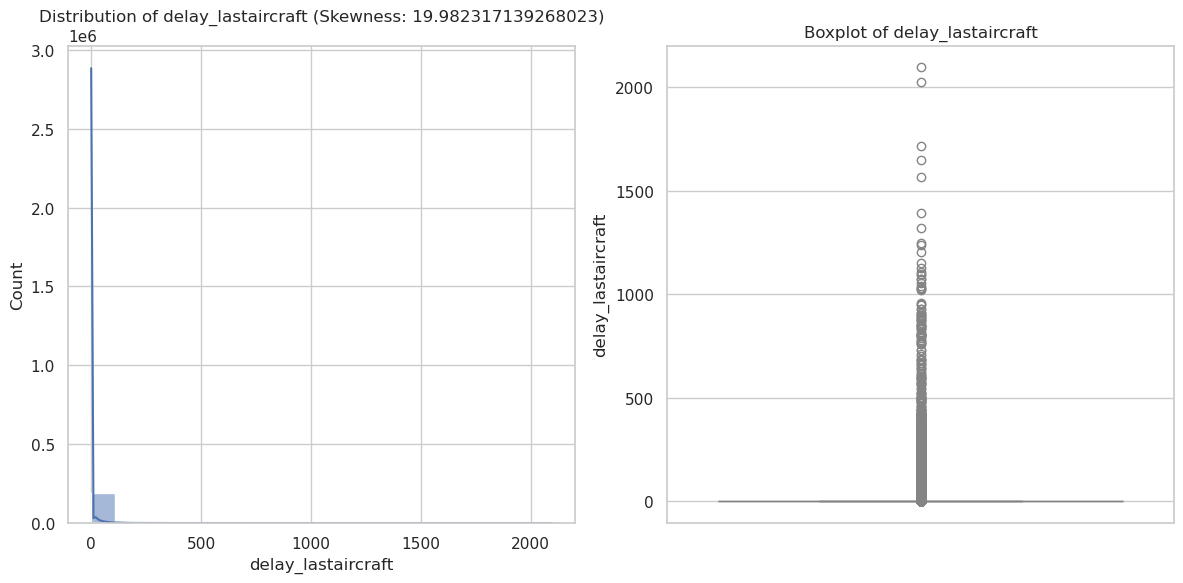

Square Root transformation skewness: 5.137339153386135
Best transformation for delay_lastaircraft: Square Root


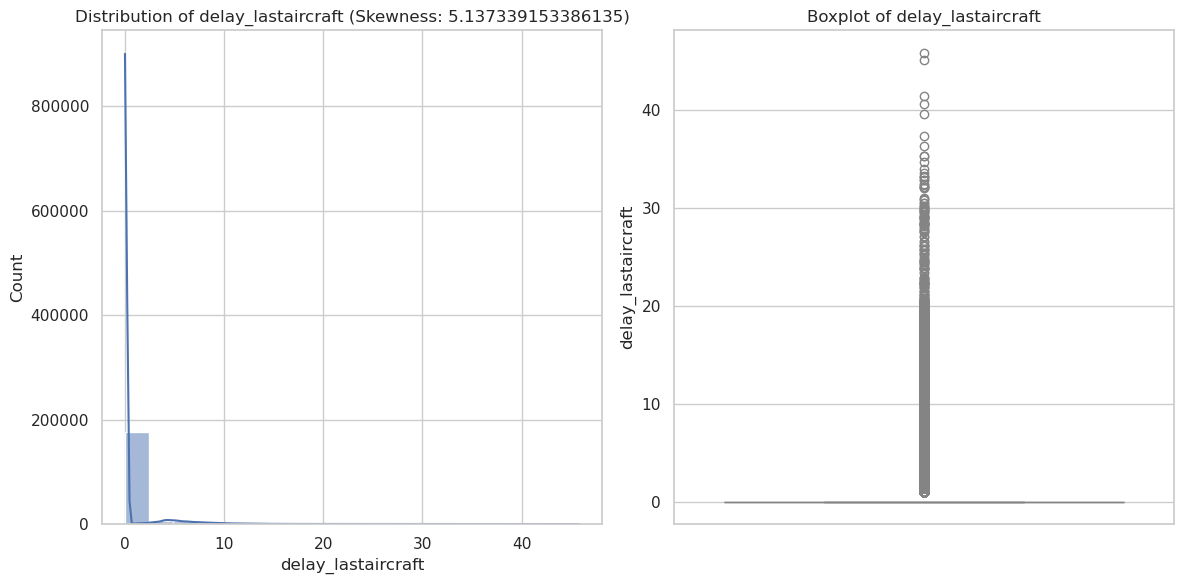


Processing column: aicraft_age


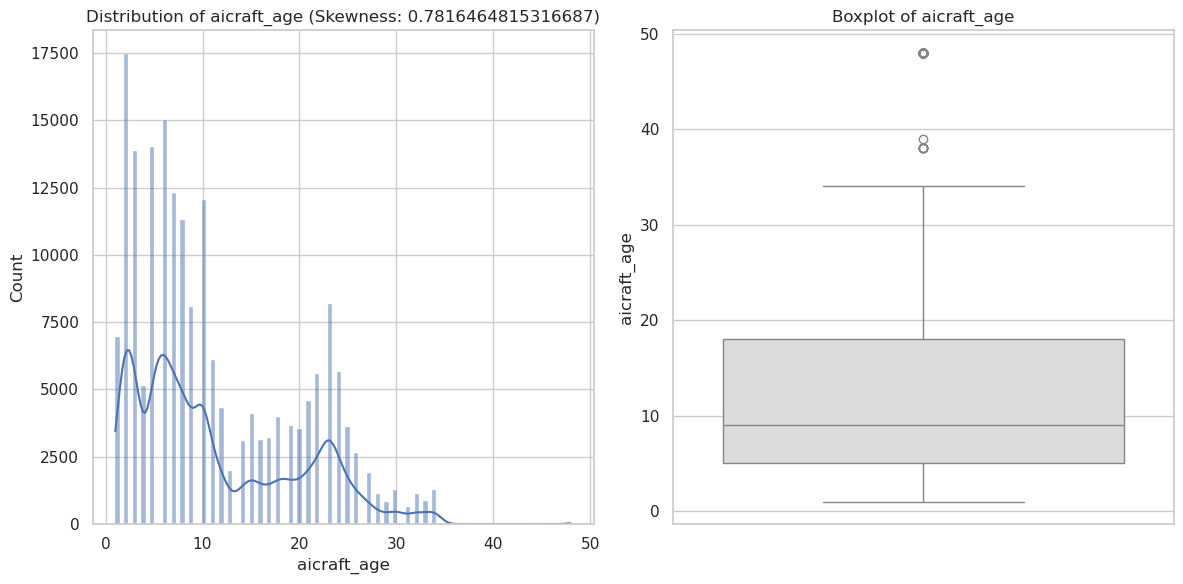

Log transformation skewness: -0.22378577730953636
Square Root transformation skewness: 0.25246183399877414
Box-Cox transformation skewness: -0.0696895338361032
Best transformation for aicraft_age: Box-Cox


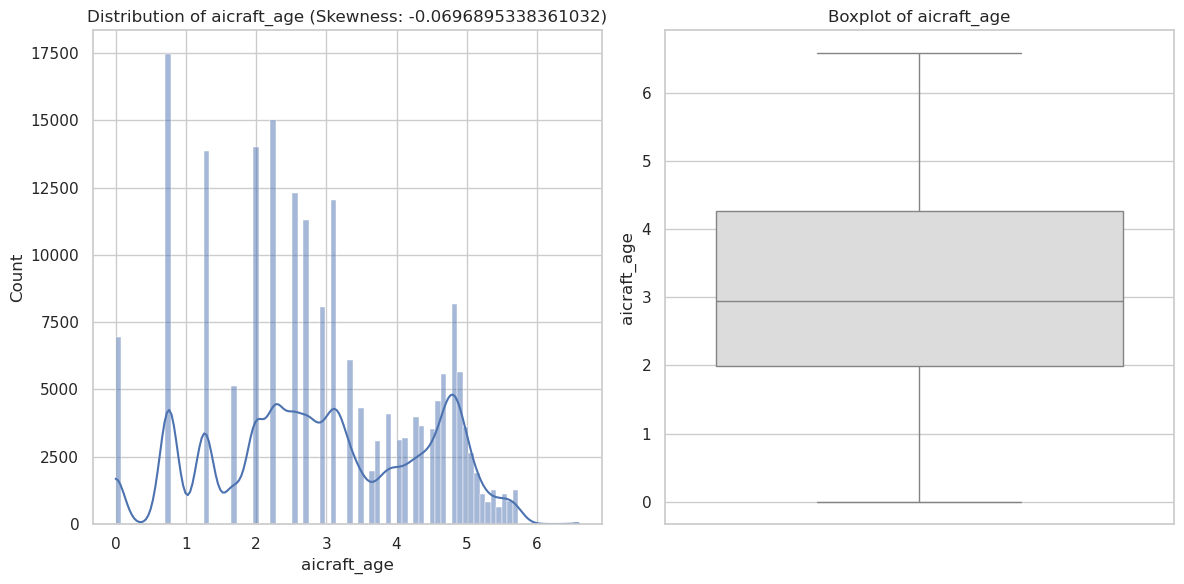


Processing column: prcp


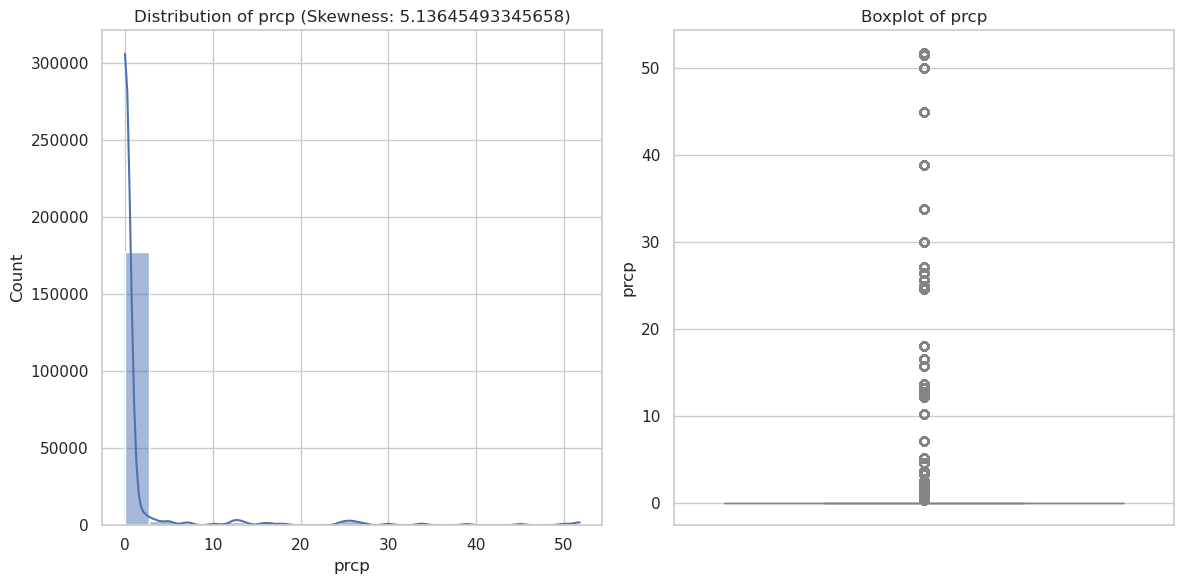

Square Root transformation skewness: 3.6512487442368817
Best transformation for prcp: Square Root


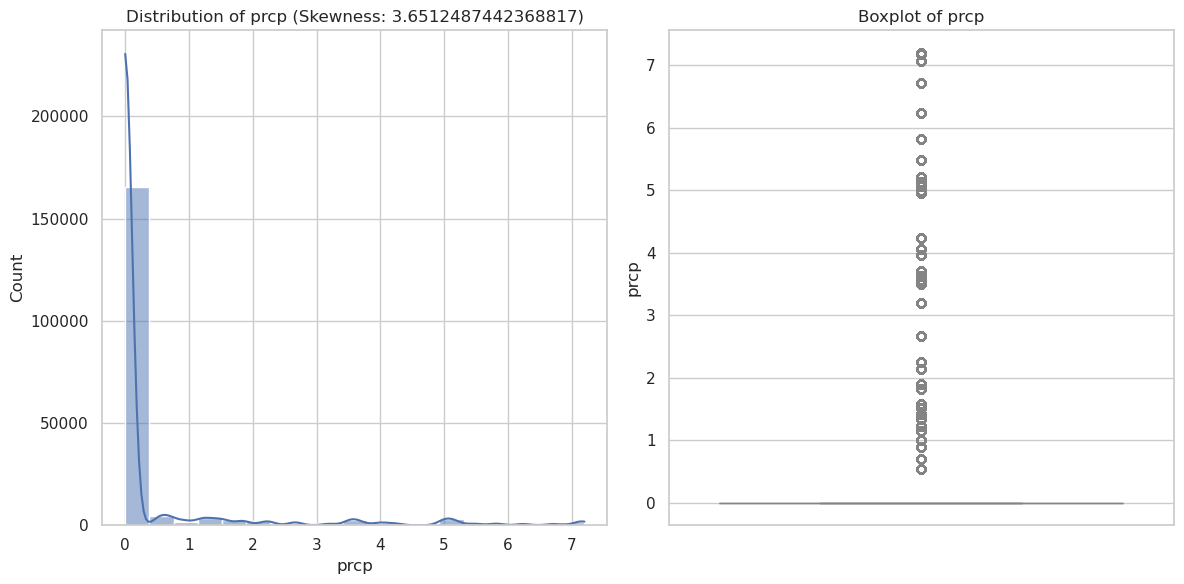


Processing column: wdir


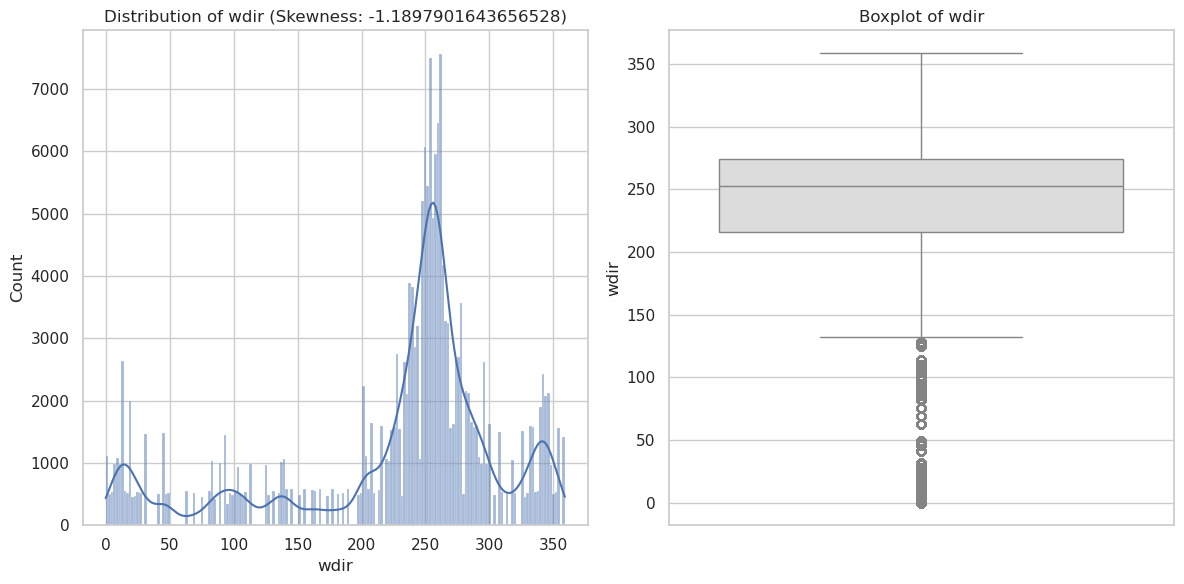

Square Root transformation skewness: -1.838539511417281
Best transformation for wdir: None


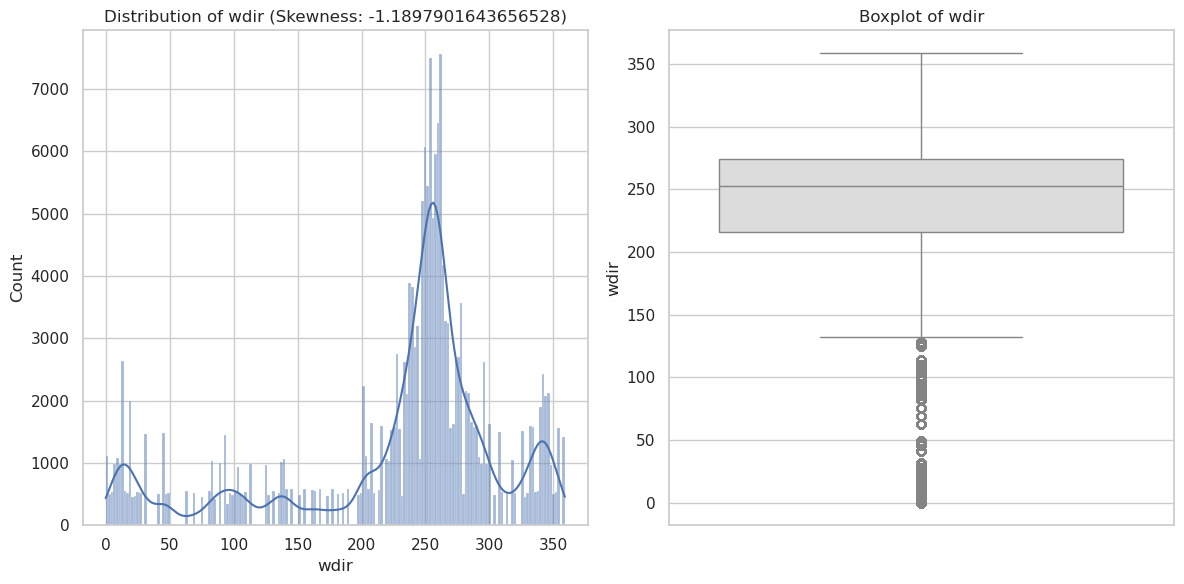


Processing column: wspd


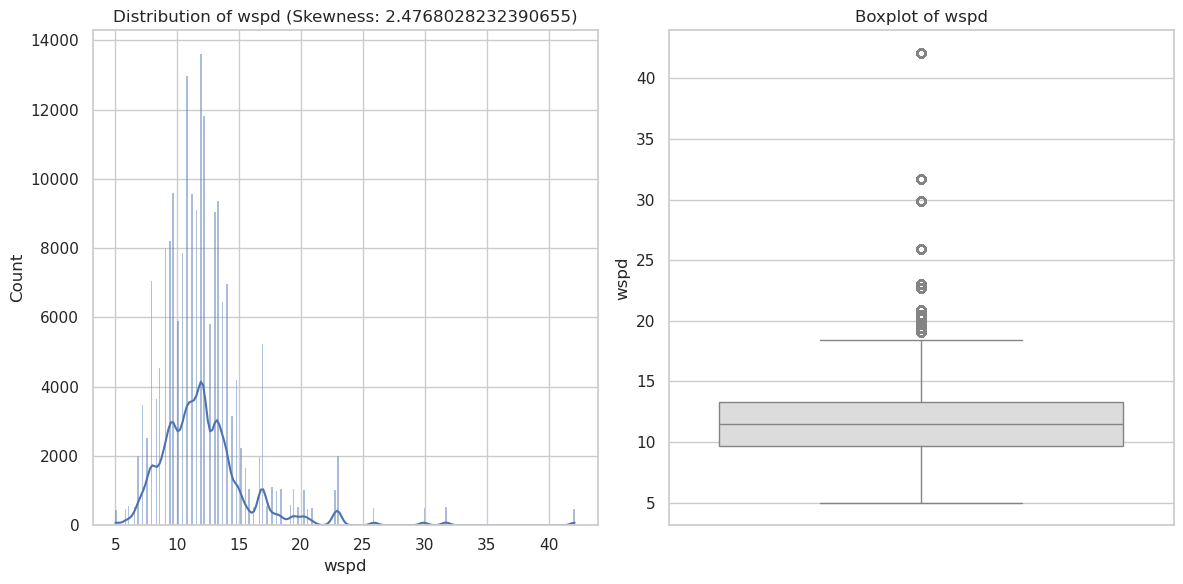

Log transformation skewness: 0.6527790982082093
Square Root transformation skewness: 1.3629298869174726
Box-Cox transformation skewness: -0.04046126879040313
Best transformation for wspd: Box-Cox


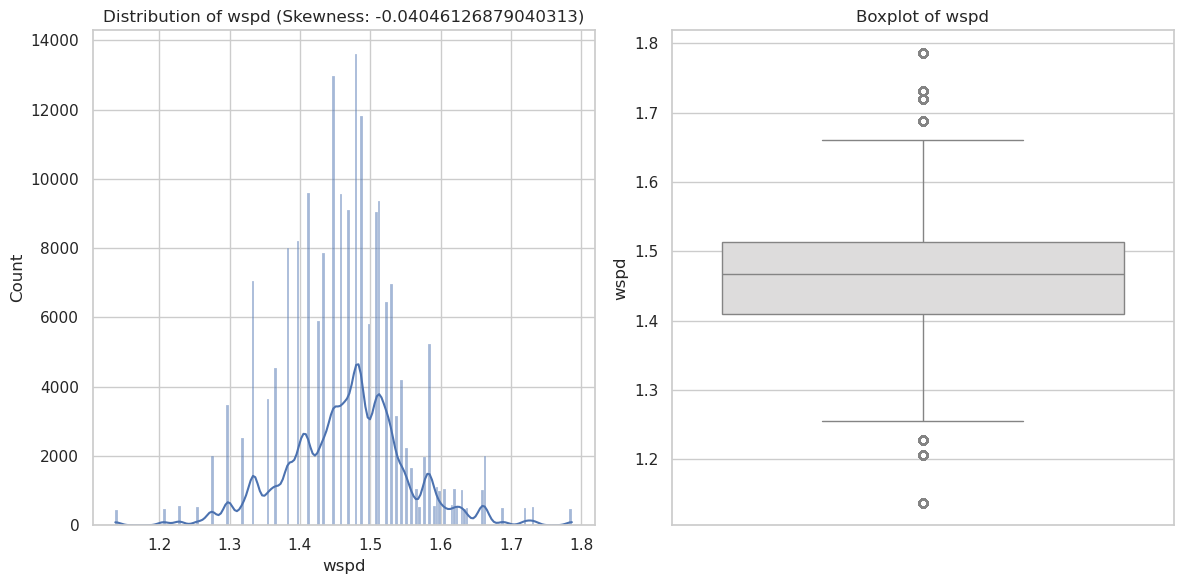

In [63]:
# Identify highly skewed columns
highly_skewed_columns = skewness_before[np.abs(skewness_before) > 0.4].index

# Apply transformations and compare skewness
best_transformations = {}

for col in highly_skewed_columns:
    print(f"\nProcessing column: {col}")
    plot_skewness(df_skew, col)

    # Original Skewness
    original_skewness = skew(df_skew[col])

    # 1. Log Transformation
    if (df_skew[col] > 0).all():  # Log transform is only applicable if all values are positive
        log_transformed = np.log1p(df_skew[col])
        log_skewness = skew(log_transformed)
        print(f"Log transformation skewness: {log_skewness}")
    else:
        log_skewness = np.inf

    # 2. Square Root Transformation
    sqrt_transformed = np.sqrt(df_skew[col])
    sqrt_skewness = skew(sqrt_transformed)
    print(f"Square Root transformation skewness: {sqrt_skewness}")

    # 3. Box-Cox Transformation (only if values are positive)
    if (df_skew[col] > 0).all():
        boxcox_transformed, _ = boxcox(df_skew[col] + 1e-6)  # Add small value to handle zeros
        boxcox_skewness = skew(boxcox_transformed)
        print(f"Box-Cox transformation skewness: {boxcox_skewness}")
    else:
        boxcox_skewness = np.inf

    # Compare and choose the best transformation
    best_transformation = min(
        (original_skewness, 'None'),
        (log_skewness, 'Log'),
        (sqrt_skewness, 'Square Root'),
        (boxcox_skewness, 'Box-Cox'),
        key=lambda x: abs(x[0])
    )

    best_transformations[col] = best_transformation[1]
    print(f"Best transformation for {col}: {best_transformations[col]}")

    # Plot the best transformation
    if best_transformation[1] == 'Log':
        df_skew[col] = log_transformed
    elif best_transformation[1] == 'Square Root':
        df_skew[col] = sqrt_transformed
    elif best_transformation[1] == 'Box-Cox':
        df_skew[col] = boxcox_transformed

    plot_skewness(df_skew, col)

In [64]:
outlier_data_after = iqr_outliers(df_skew, numerical_cols)

No. of IQR outliers in 'delay_carrier': 21573
Percentage of outliers in 'delay_carrier': 11.22%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_weather': 646
Percentage of outliers in 'delay_weather': 0.34%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_nas': 16756
Percentage of outliers in 'delay_nas': 8.72%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_security': 137
Percentage of outliers in 'delay_security': 0.07%
--------------------------------------------------------------------------------
No. of IQR outliers in 'delay_lastaircraft': 16929
Percentage of outliers in 'delay_lastaircraft': 8.81%
--------------------------------------------------------------------------------
No. of IQR outliers in 'prcp': 26635
Percentage of outliers in 'prcp': 13.85%
-----------------------------------------

## Train Model (Classification)

In [65]:
%conda install xgboost

%conda install lightgbm

%conda install mlxtend

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.9.2
    latest version: 24.11.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    libxgboost-2.1.3           |   cpu_h3a1dfae_0         3.1 MB  conda-forge
    openssl-3.4.0              |       h7b32b05_1         2.8 MB  conda-forge
    py-xgboost-2.1.3           | cpu_pyhd3de297_0         132 KB  conda-forge
    xgboost-2.1.3              | cpu_pyhac85b48_0          15 KB  conda-forge
    ----------------

In [66]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler

# Classification Models
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier,
                              VotingClassifier, GradientBoostingClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import time
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, mean_squared_error,
                             f1_score, precision_score, recall_score, roc_auc_score, mean_absolute_error,
                             roc_curve, auc, average_precision_score, precision_recall_curve, fbeta_score)
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay,
                             PrecisionRecallDisplay)
from mlxtend.plotting import plot_confusion_matrix

In [67]:
def encode_data(X_train, X_test, encoder_type='label', columns=None):
    if columns is None:
        # Default to all object type columns if no columns are specified
        columns = X_train.select_dtypes(include=['object']).columns.tolist()

    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    if encoder_type == 'label':
        for col in columns:
            le = LabelEncoder()
            X_train_encoded[col] = le.fit_transform(X_train[col])
            X_test_encoded[col] = le.transform(X_test[col])
    elif encoder_type == 'onehot':
        for col in columns:
            ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
            encoded_train = ohe.fit_transform(X_train[[col]])
            encoded_test = ohe.transform(X_test[[col]])

            # Create a DataFrame with the encoded data
            encoded_train_df = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out([col]))
            encoded_test_df = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out([col]))

            # Concatenate the new columns to the original dataframes and drop the original columns
            X_train_encoded = pd.concat([X_train_encoded.drop(col, axis=1), encoded_train_df], axis=1)
            X_test_encoded = pd.concat([X_test_encoded.drop(col, axis=1), encoded_test_df], axis=1)

    return X_train_encoded, X_test_encoded

In [68]:
def encode_target(y_train, y_test, encoder_type='label'):
    if encoder_type == 'label':
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        y_test_encoded = encoder.transform(y_test)
    else:
        raise ValueError("Invalid encoder_type. Currently supported: 'label'.")

    y_train_encoded = pd.Series(y_train_encoded, index=y_train.index)
    y_test_encoded = pd.Series(y_test_encoded, index=y_test.index)

    return y_train_encoded, y_test_encoded

In [69]:
def scale_data(X_train, X_test, scaler_type='standard', columns=None):
    if columns is None:
        # Default to all numeric columns if no columns are specified
        columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaler_type. Choose from 'standard', 'minmax', 'robust'.")

    X_train_scaled[columns] = scaler.fit_transform(X_train[columns])
    X_test_scaled[columns] = scaler.transform(X_test[columns])

    return X_train_scaled, X_test_scaled

In [70]:
def evaluate_classification_models(X_train, y_train, X_test, y_test, models):
    model_results = []
    trained_models = {}
    
    for model in models:
        model.fit(X_train, y_train)
        trained_models[model.__class__.__name__] = model  # Save trained model with name
        start_time = time.time()  # Record start time
        prediction = model.predict(X_test)
        prediction_train = model.predict(X_train)
        inference_time = time.time() - start_time  # Calculate inference time

        print(f"{model} is ready")

        model_results.append({
            "Model-Name": model.__class__.__name__,
            "Test_Accuracy": accuracy_score(y_test, prediction) * 100,
            "Train_Accuracy": accuracy_score(y_train, prediction_train) * 100,
            "ROC_AUC": roc_auc_score(y_test, prediction),
            "F1_Score": f1_score(y_test, prediction, average="weighted"),
            "Precision": precision_score(y_test, prediction),
            "Recall": recall_score(y_test, prediction),
            "Inference Time (ms)": inference_time * 1000,
            "Prediction": prediction,
        })

    models_df = pd.DataFrame(model_results)
    models_df = models_df.set_index('Model-Name')
    
    return models_df.sort_values("Test_Accuracy", ascending=False), trained_models

In [71]:
def evaluate_classification_metrics(y_true, y_pred, target_names=None, display=True):
    # Ensure y_true and y_pred are NumPy arrays for compatibility with sklearn metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=target_names)

    # Optionally display confusion matrix visually
    if display:
        ConfusionMatrixDisplay(cm, display_labels=target_names).plot()
        plt.show()  # Display the confusion matrix plot

    cm_normalized = plot_confusion_matrix(conf_mat=cm, class_names=target_names, show_normed=True)

    # Return results in a dictionary for easy access
    evaluation_results = {
        "Confusion Matrix": cm,
        "Confusion Matrix Normalized": cm_normalized,
        "Classification Report": report,
        "Target Names": target_names,  # Include target names if provided
    }

    return evaluation_results

In [72]:
classification_models = [
    BaggingClassifier(random_state=42),

    LogisticRegression(random_state=42),

    GaussianNB(),

    RandomForestClassifier(random_state=42),

    DecisionTreeClassifier(random_state=42),

    GradientBoostingClassifier(random_state=42),

    AdaBoostClassifier(random_state=42),

    XGBClassifier(random_state=42),

    XGBRFClassifier(random_state=42),

    LGBMClassifier(random_state=42)

]

In [73]:
# Separate the data into the two classes (0 and 1)
class_0 = df[df["dep_delay_tag"] == 0]
class_1 = df[df['dep_delay_tag'] == 1]

# the minimum count
count = 70948

# Randomly sample 'min_count' rows from each class
class_0_sample = class_0.sample(n=count, random_state=42)
class_1_sample = class_1.sample(n=count, random_state=42)

# Combine the samples into a new balanced dataset
df = pd.concat([class_0_sample, class_1_sample])

# Shuffle the dataset to mix the rows from both classes
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [74]:
# Split to X, y
X = df.drop(columns=['dep_delay_tag', "dep_delay", "flightdate", "tail_number",
                     "dep_airport", "dep_cityname", "snow", "tmin", "tmax", "day", "month", "quarter",
                     "delay_carrier", "delay_nas", "delay_security", "delay_lastaircraft"])

y = df['dep_delay_tag']  # Target variable

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [76]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

num_cols = [col for col in X_train.columns if X_train[col].dtype != "object"]

In [77]:
X_train_encoded, X_test_encoded = encode_data(X_train, X_test)

In [78]:
y_train_encoded, y_test_encoded = encode_target(y_train, y_test)

In [79]:
models_class_no_s, trained_no_s = evaluate_classification_models(X_train_encoded, y_train_encoded, X_test_encoded,
                                                                 y_test_encoded, classification_models)

BaggingClassifier(random_state=42) is ready
LogisticRegression(random_state=42) is ready
GaussianNB() is ready
RandomForestClassifier(random_state=42) is ready
DecisionTreeClassifier(random_state=42) is ready
GradientBoostingClassifier(random_state=42) is ready
AdaBoostClassifier(random_state=42) is ready
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=Non

In [80]:
models_class_no_s.iloc[:, :-1]

,Test_Accuracy,Train_Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms)
Model-Name,,,,,,,
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,318.487167
LGBMClassifier,85.366455,86.024878,0.853665,0.853239,0.896375,0.799789,939.405441
RandomForestClassifier,84.601832,100.000000,0.846018,0.845595,0.886492,0.793658,3362.669706
BaggingClassifier,84.400987,98.996617,0.844010,0.843503,0.888191,0.787104,642.120838
GradientBoostingClassifier,81.462297,81.760280,0.814623,0.813902,0.859374,0.752361,264.107704
AdaBoostClassifier,80.563777,80.563973,0.805638,0.804777,0.852430,0.739253,737.075329
DecisionTreeClassifier,80.239605,100.000000,0.802396,0.802393,0.800112,0.806202,43.000937
XGBRFClassifier,79.943622,79.970224,0.799436,0.798578,0.844383,0.734179,275.341034
LogisticRegression,77.329105,77.277212,0.773291,0.772426,0.811736,0.711628,12.120008


In [81]:
X_train_ss, X_test_ss = scale_data(X_train_encoded, X_test_encoded, scaler_type="standard")

In [82]:
models_class_ss, trained_ss = evaluate_classification_models(X_train_ss, y_train_encoded, X_test_ss,
                                                             y_test_encoded, classification_models)

models_class_ss.iloc[:, :-1]

BaggingClassifier(random_state=42) is ready
LogisticRegression(random_state=42) is ready
GaussianNB() is ready
RandomForestClassifier(random_state=42) is ready
DecisionTreeClassifier(random_state=42) is ready
GradientBoostingClassifier(random_state=42) is ready
AdaBoostClassifier(random_state=42) is ready
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=Non

,Test_Accuracy,Train_Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms)
Model-Name,,,,,,,
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,260.833740
LGBMClassifier,85.221987,85.988759,0.852220,0.851745,0.897171,0.795631,1072.199106
RandomForestClassifier,84.651163,100.000000,0.846512,0.846090,0.887043,0.794151,4478.033304
BaggingClassifier,84.372798,98.994855,0.843728,0.843215,0.888120,0.786540,357.562780
GradientBoostingClassifier,81.462297,81.760280,0.814623,0.813902,0.859374,0.752361,245.980024
AdaBoostClassifier,80.563777,80.563973,0.805638,0.804777,0.852430,0.739253,693.136454
DecisionTreeClassifier,80.236082,100.000000,0.802361,0.802357,0.799637,0.806906,50.773859
XGBRFClassifier,79.943622,79.970224,0.799436,0.798578,0.844383,0.734179,254.817724
LogisticRegression,79.538407,79.492759,0.795384,0.794458,0.841188,0.728259,7.482052


In [83]:
X_train_sm, X_test_sm = scale_data(X_train_encoded, X_test_encoded, scaler_type="minmax")

In [84]:
models_class_mm, trained_mm = evaluate_classification_models(X_train_sm, y_train_encoded, X_test_sm,
                                                             y_test_encoded, classification_models)

models_class_mm.iloc[:, :-1]

BaggingClassifier(random_state=42) is ready
LogisticRegression(random_state=42) is ready
GaussianNB() is ready
RandomForestClassifier(random_state=42) is ready
DecisionTreeClassifier(random_state=42) is ready
GradientBoostingClassifier(random_state=42) is ready
AdaBoostClassifier(random_state=42) is ready
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=Non

,Test_Accuracy,Train_Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms)
Model-Name,,,,,,,
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,269.176722
LGBMClassifier,85.359408,85.980831,0.853594,0.853131,0.898309,0.797463,879.316330
RandomForestClassifier,84.619450,100.000000,0.846195,0.845771,0.886720,0.793798,3417.667866
BaggingClassifier,84.372798,98.989570,0.843728,0.843218,0.887996,0.786681,420.243502
GradientBoostingClassifier,81.462297,81.760280,0.814623,0.813902,0.859374,0.752361,247.081518
AdaBoostClassifier,80.563777,80.563973,0.805638,0.804777,0.852430,0.739253,578.047276
DecisionTreeClassifier,80.211416,100.000000,0.802114,0.802111,0.799874,0.805849,38.678646
XGBRFClassifier,79.943622,79.970224,0.799436,0.798578,0.844383,0.734179,261.458874
LogisticRegression,78.661029,78.795060,0.786610,0.784330,0.860806,0.683791,8.367538


In [85]:
X_train_sr, X_test_sr = scale_data(X_train_encoded, X_test_encoded, scaler_type="robust")

In [86]:
models_class_rs, trained_rs = evaluate_classification_models(X_train_sr, y_train_encoded, X_test_sr,
                                                             y_test_encoded, classification_models)

models_class_rs.iloc[:, :-1]

BaggingClassifier(random_state=42) is ready
LogisticRegression(random_state=42) is ready
GaussianNB() is ready
RandomForestClassifier(random_state=42) is ready
DecisionTreeClassifier(random_state=42) is ready
GradientBoostingClassifier(random_state=42) is ready
AdaBoostClassifier(random_state=42) is ready
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=Non

,Test_Accuracy,Train_Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms)
Model-Name,,,,,,,
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,273.423433
LGBMClassifier,85.179704,85.902428,0.851797,0.851355,0.894874,0.797252,977.052689
RandomForestClassifier,84.612403,100.000000,0.846124,0.845702,0.886580,0.793798,4004.254580
BaggingClassifier,84.362227,98.993974,0.843622,0.843103,0.888278,0.786117,390.017509
GradientBoostingClassifier,81.462297,81.760280,0.814623,0.813902,0.859374,0.752361,255.207777
AdaBoostClassifier,80.563777,80.563973,0.805638,0.804777,0.852430,0.739253,556.841135
DecisionTreeClassifier,80.253700,100.000000,0.802537,0.802534,0.800042,0.806695,39.806843
XGBRFClassifier,79.943622,79.970224,0.799436,0.798578,0.844383,0.734179,400.954723
LogisticRegression,79.541931,79.487473,0.795419,0.794498,0.841090,0.728471,9.146929


In [87]:
models_class_no_s["Scaler"] = "No Scaling"
models_class_ss["Scaler"] = "Standard Scaler"
models_class_mm["Scaler"] = "MinMax Scaler"
models_class_rs["Scaler"] = "Robust Scaler"


all_models = pd.concat([models_class_no_s, models_class_ss, models_class_mm, models_class_rs], axis=0)
all_models = all_models.drop(columns=["Prediction"])
all_models = all_models.sort_values(by="Test_Accuracy", ascending=False)
all_models

,Test_Accuracy,Train_Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms),Scaler
Model-Name,,,,,,,,
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,318.487167,No Scaling
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,273.423433,Robust Scaler
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,269.176722,MinMax Scaler
XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,260.833740,Standard Scaler
LGBMClassifier,85.366455,86.024878,0.853665,0.853239,0.896375,0.799789,939.405441,No Scaling
LGBMClassifier,85.359408,85.980831,0.853594,0.853131,0.898309,0.797463,879.316330,MinMax Scaler
LGBMClassifier,85.221987,85.988759,0.852220,0.851745,0.897171,0.795631,1072.199106,Standard Scaler
LGBMClassifier,85.179704,85.902428,0.851797,0.851355,0.894874,0.797252,977.052689,Robust Scaler
RandomForestClassifier,84.651163,100.000000,0.846512,0.846090,0.887043,0.794151,4478.033304,Standard Scaler


## The Best Model
**Extreme Gradient Boosting (XGBoost)** with no scaling is our best model to detect whether the flight is going to be delayed or not

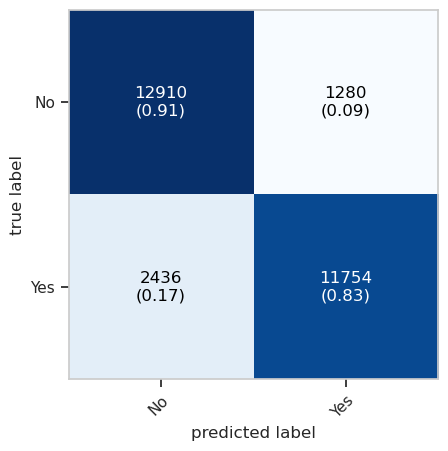

In [88]:
xgb_result = evaluate_classification_metrics(y_test_encoded, models_class_no_s["Prediction"][0], target_names=["No","Yes"], display=False)

In [89]:
print(xgb_result['Classification Report'])

              precision    recall  f1-score   support

          No       0.84      0.91      0.87     14190
         Yes       0.90      0.83      0.86     14190

    accuracy                           0.87     28380
   macro avg       0.87      0.87      0.87     28380
weighted avg       0.87      0.87      0.87     28380



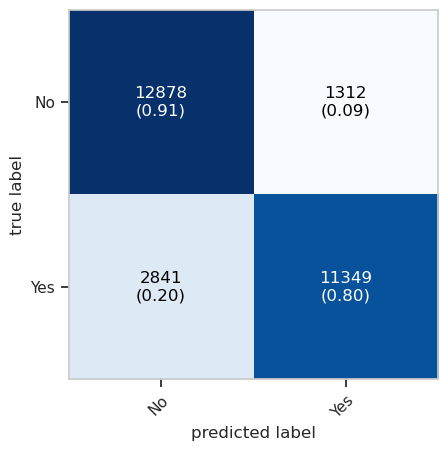

In [94]:
lgbm_result = evaluate_classification_metrics(y_test_encoded, models_class_no_s["Prediction"][1], target_names=["No","Yes"], display=False)

In [95]:
print(lgbm_result["Classification Report"])

              precision    recall  f1-score   support

          No       0.82      0.91      0.86     14190
         Yes       0.90      0.80      0.85     14190

    accuracy                           0.85     28380
   macro avg       0.86      0.85      0.85     28380
weighted avg       0.86      0.85      0.85     28380



In [92]:
results_df = all_models.reset_index()

results_df

,Model-Name,Test_Accuracy,Train_Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms),Scaler
0,XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,318.487167,No Scaling
1,XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,273.423433,Robust Scaler
2,XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,269.176722,MinMax Scaler
3,XGBClassifier,86.906272,89.124881,0.869063,0.868845,0.901795,0.828330,260.833740,Standard Scaler
4,LGBMClassifier,85.366455,86.024878,0.853665,0.853239,0.896375,0.799789,939.405441,No Scaling
5,LGBMClassifier,85.359408,85.980831,0.853594,0.853131,0.898309,0.797463,879.316330,MinMax Scaler
6,LGBMClassifier,85.221987,85.988759,0.852220,0.851745,0.897171,0.795631,1072.199106,Standard Scaler
7,LGBMClassifier,85.179704,85.902428,0.851797,0.851355,0.894874,0.797252,977.052689,Robust Scaler
8,RandomForestClassifier,84.651163,100.000000,0.846512,0.846090,0.887043,0.794151,4478.033304,Standard Scaler
9,RandomForestClassifier,84.619450,100.000000,0.846195,0.845771,0.886720,0.793798,3417.667866,MinMax Scaler


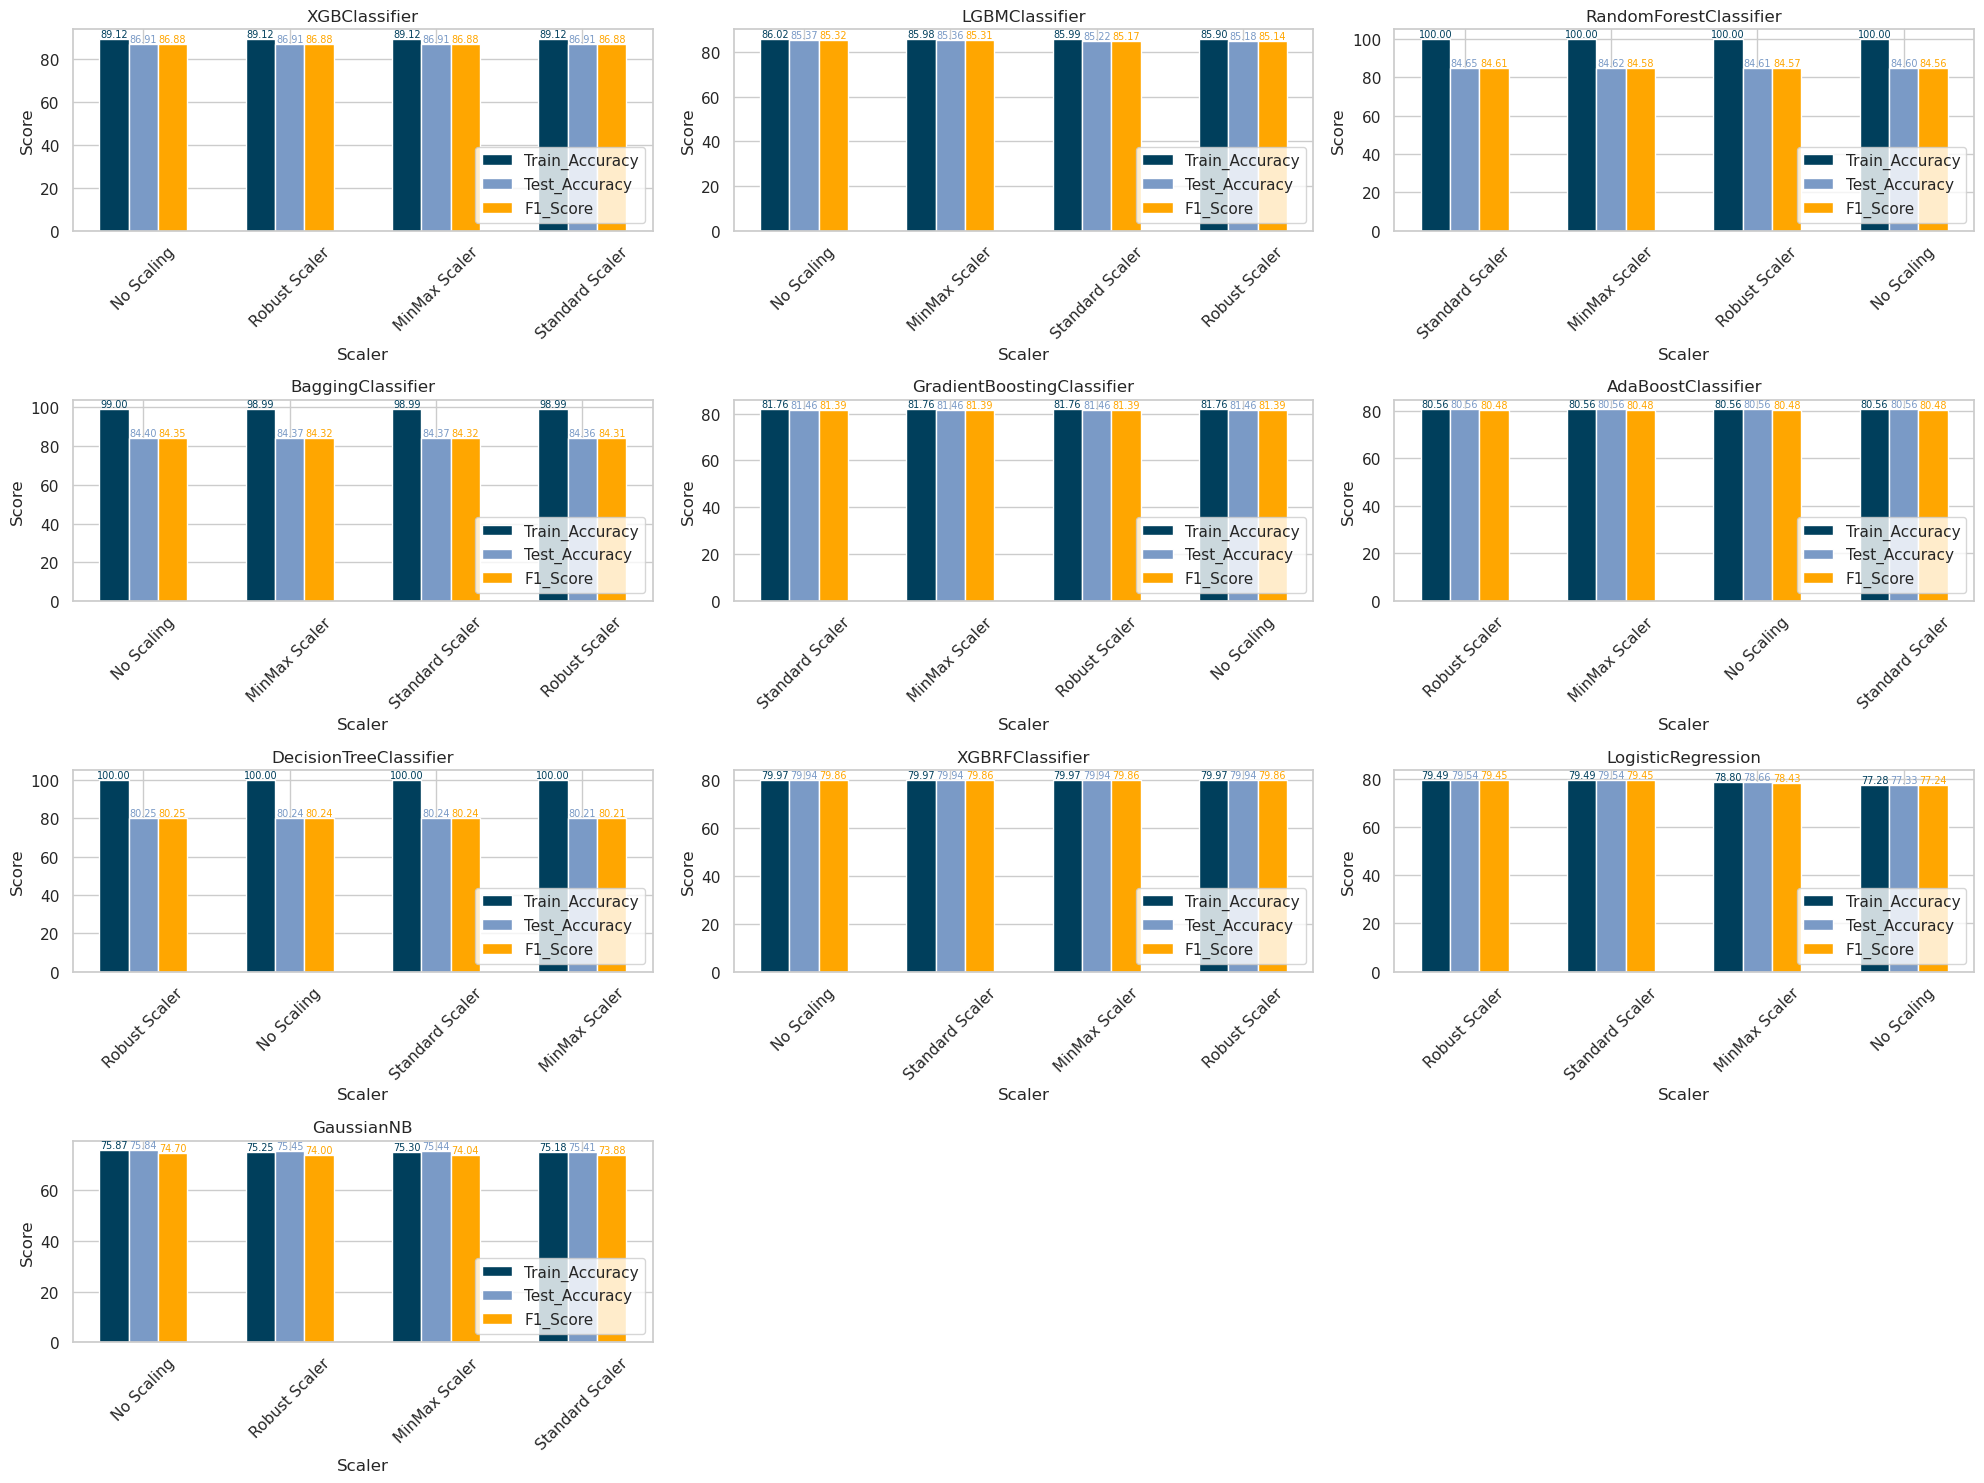

In [93]:
fig_width = 20
fig_height = 15
models = results_df['Model-Name'].unique()
n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), tight_layout=True)
axes = axes.flatten()


train_color_acc = '#003f5c'
test_color_acc = '#7a9ac6'
train_color_f1 = '#bc5090'
test_color_f1 = '#ffa600'

for ax, model in zip(axes, models):
    model_df = results_df[results_df['Model-Name'] == model]
    scalers = model_df['Scaler']
    bar_width = 0.2  # Adjusted bar width to fit all bars
    index = np.arange(len(scalers))

    # Plot Accuracy bars
    train_acc_bars = ax.bar(index - bar_width, model_df['Train_Accuracy'], bar_width, label='Train_Accuracy', color=train_color_acc)
    test_acc_bars = ax.bar(index, model_df['Test_Accuracy'], bar_width, label='Test_Accuracy', color=test_color_acc)

    # Plot F1 Score bars
    test_f1_bars = ax.bar(index + bar_width, model_df['F1_Score']*100, bar_width, label='F1_Score', color=test_color_f1)
    ax.set_xlabel('Scaler')
    ax.set_ylabel('Score')
    ax.set_title(model)
    ax.set_xticks(index)
    ax.set_xticklabels(scalers, rotation=45)
    ax.legend()

    # Add text above bars for Accuracy
    for bar in train_acc_bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=7, color=train_color_acc)
        ax.legend(loc='lower right')

    for bar in test_acc_bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=7, color=test_color_acc)
        ax.legend(loc='lower right')

    for bar in test_f1_bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=7, color=test_color_f1)
        ax.legend(loc='lower right')

# Remove any unused subplots
for i in range(len(models), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()